# Imports

In [3]:
import pandas as pd
import random
import re
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torch.optim import Adam
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
import os
import glob
import psutil
import uuid
import time

nltk.download(['punkt', 'stopwords', 'wordnet', 'omw-1.4'])
plt.style.use('seaborn')
sns.set_palette("tab10")

2025-05-23 17:06:19.403769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748019979.705181      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748019979.787909      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
/tmp/ipyke

# Load JSONL

In [4]:
import json

def load_jsonl(file_path):
    return pd.DataFrame([json.loads(line) for line in open(file_path)])

train_df = load_jsonl('/kaggle/input/data/train.jsonl')
dev_df = load_jsonl('/kaggle/input/data/dev.jsonl')
test_df = load_jsonl('/kaggle/input/data/test.jsonl')

df = pd.concat([train_df, dev_df, test_df], ignore_index=True)
image_dir = '/kaggle/input/data/'

# Plot Class Distribution

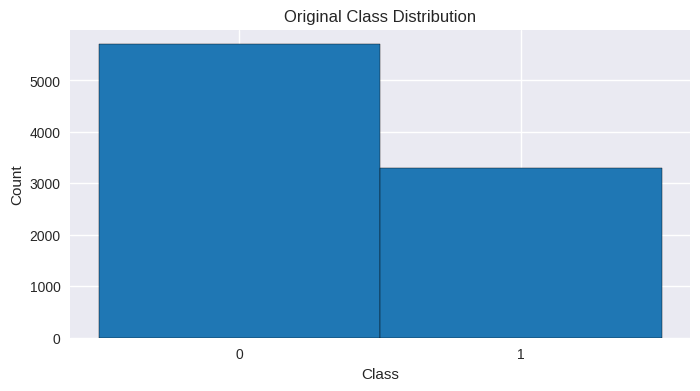

In [5]:
def plot_class_distribution(labels, title, writer=None, epoch=0):
    plt.figure(figsize=(8, 4))
    plt.hist(labels, bins=[-0.5, 0.5, 1.5], edgecolor='black')
    plt.xticks([0, 1])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    if writer:
        plt.savefig('temp.png')
        writer.add_figure('Class Distribution', plt.gcf(), epoch)
        plt.close()
    else:
        plt.show()

plot_class_distribution(df['label'], 'Original Class Distribution')

# Augmentation and Balancing

In [6]:
def synonym_replacement(text, n=2):
    words = word_tokenize(text)
    new_words = words.copy()
    random.shuffle(new_words)
    replaced = 0
    
    for i, word in enumerate(new_words):
        if word in stopwords.words('english') or not word.isalpha():
            continue
        synonyms = wordnet.synsets(word)
        if synonyms:
            syn_list = [lemma.name() for syn in synonyms for lemma in syn.lemmas()]
            syn_list = list(set(syn_list))
            if word in syn_list:
                syn_list.remove(word)
            if syn_list:
                replacement = random.choice(syn_list).replace('_', ' ')
                words[words.index(word)] = replacement
                replaced += 1
        if replaced >= n:
            break
    return ' '.join(words)

augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
])

minority_class = df[df['label'] == 1]
majority_class = df[df['label'] == 0]
diff = len(majority_class) - len(minority_class)

augmented_samples = []
for _ in range(diff):
    sample = minority_class.sample(1).iloc[0]
    img = Image.open(image_dir + sample['img'])
    img = augmentation_transform(img)
    new_text = synonym_replacement(sample['text'])
    augmented_samples.append({
        'id': f"aug_{sample['id']}",
        'img': sample['img'],
        'text': new_text,
        'label': 1
    })

augmented_df = pd.DataFrame(augmented_samples)
balanced_df = pd.concat([majority_class, minority_class, augmented_df]).sample(frac=1)

# Text Preprocessing

In [7]:
def preprocess_text(text, for_bert=False):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    if not for_bert:
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        tokens = [WordNetLemmatizer().lemmatize(t) for t in tokens if t not in stop_words]
        return ' '.join(tokens), tokens
    return text, word_tokenize(text.lower())

balanced_df[['text_clean', 'tokens']] = balanced_df['text'].apply(lambda x: preprocess_text(x)).apply(pd.Series)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# MemeDataset

In [8]:
class MemeDataset(Dataset):
    def __init__(self, df, img_dir, text_mode='bert', max_length=128, transform=None):
        self.df = df.dataset if isinstance(df, torch.utils.data.Subset) else df
        self.indices = df.indices if isinstance(df, torch.utils.data.Subset) else None
        self.img_dir = img_dir
        self.text_mode = text_mode
        self.max_length = max_length
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.indices) if self.indices is not None else len(self.df)
    
    def __getitem__(self, idx):
        if self.indices is not None:
            row = self.df.iloc[self.indices[idx]]
        else:
            row = self.df.iloc[idx]
        img_path = self.img_dir + row['img']
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(row['label'], dtype=torch.long)
        
        if self.transform:
            image = self.transform(image)
        
        if self.text_mode == 'bert':
            encoding = bert_tokenizer.encode_plus(
                row['text'],
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            return {
                'image': image,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': label,
                'text': row['text'],
                'img_path': img_path
            }
        else:
            text = row['text_clean']
            tokens = word_tokenize(text)
            if len(tokens) == 0:
                tokens = [bert_tokenizer.pad_token]
            token_ids = bert_tokenizer.convert_tokens_to_ids(tokens)
            return {
                'image': image,
                'text': torch.tensor(token_ids, dtype=torch.long),
                'label': label,
                'text_raw': row['text'],
                'img_path': img_path
            }

# Collate Function and Loaders

In [9]:
def collate_fn(batch):
    images = torch.stack([item['image'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])
    img_paths = [item['img_path'] for item in batch]
    texts = [item.get('text', item.get('text_raw', '')) for item in batch]
    
    if 'input_ids' in batch[0]:
        input_ids = torch.stack([item['input_ids'] for item in batch])
        attention_masks = torch.stack([item['attention_mask'] for item in batch])
        return {
            'image': images,
            'input_ids': input_ids,
            'attention_mask': attention_masks,
            'label': labels,
            'text': texts,
            'img_path': img_paths
        }
    else:
        texts_tensor = [item['text'] for item in batch]
        lengths = torch.tensor([len(t) for t in texts_tensor], dtype=torch.long)
        padded_texts = torch.nn.utils.rnn.pad_sequence(texts_tensor, batch_first=True, padding_value=bert_tokenizer.pad_token_id)
        return {
            'image': images,
            'text': padded_texts,
            'lengths': lengths,
            'label': labels,
            'text_raw': texts,
            'img_path': img_paths
        }

train_size = int(0.8 * len(balanced_df))
val_size = len(balanced_df) - train_size
train_dataset, val_dataset = random_split(balanced_df, [train_size, val_size])

bert_train_dataset = MemeDataset(train_dataset, image_dir, text_mode='bert')
bert_val_dataset = MemeDataset(val_dataset, image_dir, text_mode='bert')
lstm_train_dataset = MemeDataset(train_dataset, image_dir, text_mode='lstm')
lstm_val_dataset = MemeDataset(val_dataset, image_dir, text_mode='lstm')

batch_size = 32
bert_train_loader = DataLoader(bert_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
bert_val_loader = DataLoader(bert_val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
lstm_train_loader = DataLoader(lstm_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
lstm_val_loader = DataLoader(lstm_val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Shared Model Components

In [10]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-05-23 17:07:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-23 17:07:55--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-23 17:07:55--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [11]:
class TextLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=300, hidden_dim=256, num_layers=2):
        super().__init__()
        glove_path = '/kaggle/working/glove.6B.300d.txt'
        try:
            embedding_matrix = self.load_glove_embeddings(glove_path, bert_tokenizer, embedding_dim)
        except FileNotFoundError:
            print(f"GloVe file not found at {glove_path}. Initializing random embeddings.")
            embedding_matrix = np.random.normal(0, 0.1, (vocab_size, embedding_dim))
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            bidirectional=True, batch_first=True, dropout=0.5)
        self.dropout = nn.Dropout(0.5)
        
    def load_glove_embeddings(self, path, tokenizer, embedding_dim):
        embeddings = {}
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                embeddings[word] = vector
        embedding_matrix = np.zeros((len(tokenizer.vocab), embedding_dim))
        for word, idx in tokenizer.vocab.items():
            embedding_vector = embeddings.get(word)
            if embedding_vector is not None:
                embedding_matrix[idx] = embedding_vector
        return embedding_matrix
    
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = self.dropout(torch.cat((hidden[-2], hidden[-1]), dim=1))
        return hidden

class TextBERT(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.5)
        for param in self.bert.parameters():
            param.requires_grad = True
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return self.dropout(outputs.pooler_output)

class ImageCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128*28*28, 512), nn.ReLU(), nn.Dropout(0.5)
        )
        
    def forward(self, images):
        return self.cnn(images)

class ImageResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        for name, param in self.resnet.named_parameters():
            if 'layer4' in name or 'fc' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
    def forward(self, images):
        features = self.resnet(images)
        return self.dropout(self.relu(features))

# Word Cloud and Sample Meme Visualization

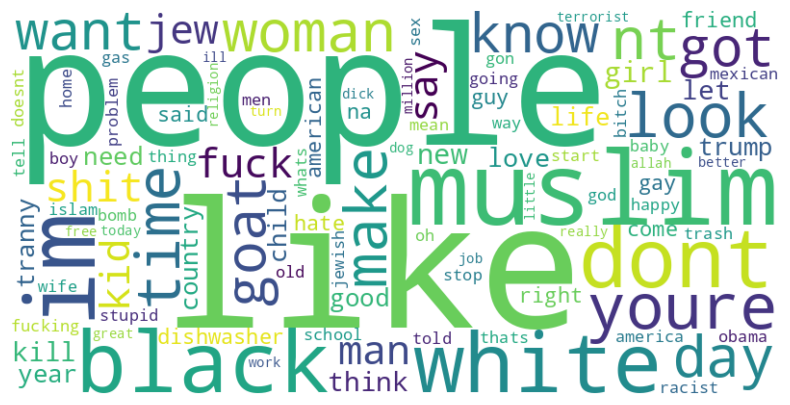

In [12]:
def generate_wordcloud(df, text_column='text'):
    # Use tokens if available, otherwise use raw text
    if 'tokens' in df.columns:
        text_data = [' '.join(tokens) if isinstance(tokens, list) else str(tokens) 
                    for tokens in df['tokens'].dropna()]
    else:
        text_data = df[text_column].dropna().astype(str).tolist()
    
    tfidf = TfidfVectorizer(max_features=100, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(text_data)
    feature_names = tfidf.get_feature_names_out()
    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    word_scores = dict(zip(feature_names, tfidf_scores))
    
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=100,
        colormap='viridis'
    ).generate_from_frequencies(word_scores)
    
    # Display only the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate word cloud
generate_wordcloud(balanced_df, text_column='text')

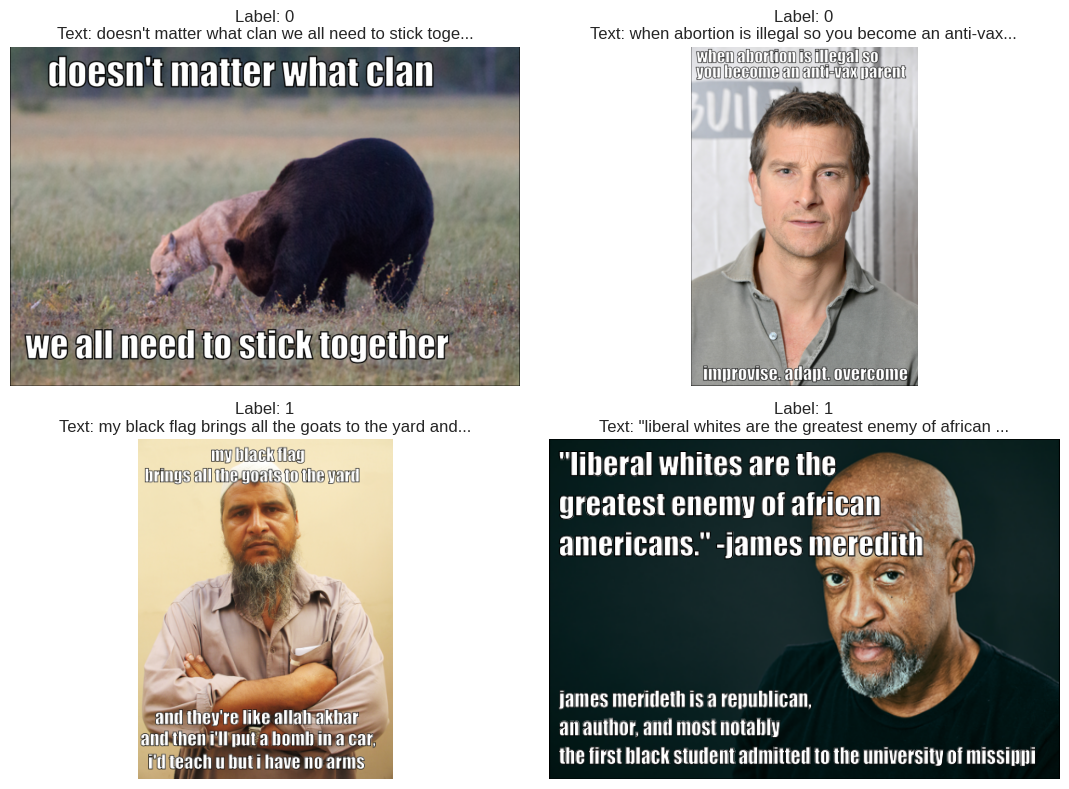

In [14]:
def display_sample_memes(dataset, num_samples=4):
    indices = random.sample(range(len(dataset)), num_samples)
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(indices):
        sample = dataset[idx]
        img = Image.open(sample['img_path']).convert('RGB')
        plt.subplot(2, 2, i+1)
        plt.imshow(img)
        plt.title(f"Label: {sample['label'].item()}\nText: {sample.get('text', sample.get('text_raw'))[:50]}...")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_sample_memes(bert_train_dataset)


# TRAIN

In [11]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name, writer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_auroc = 0
    log_data = []

    for epoch in range(num_epochs):
        start_time = time.time()
        memory_start = psutil.virtual_memory().used / 1024**3
        model.train()
        train_loss = 0
        train_preds, train_labels, train_probs = [], [], []

        for batch in train_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device).float()
            if 'input_ids' in batch:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids, attention_mask, images).squeeze()
            else:
                texts = batch['text'].to(device)
                lengths = batch['lengths'].to(device)
                valid_indices = lengths > 0
                if not valid_indices.any():
                    continue
                images = images[valid_indices]
                texts = texts[valid_indices]
                lengths = lengths[valid_indices]
                labels = labels[valid_indices]
                outputs = model(texts, lengths, images).squeeze()

            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()
            probs = torch.sigmoid(outputs).detach().cpu()
            preds = probs.round()
            train_preds.extend(preds.numpy())
            train_labels.extend(labels.cpu().numpy())
            train_probs.extend(probs.numpy())

        train_loss /= len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds)
        train_precision = precision_score(train_labels, train_preds, zero_division=0)
        train_recall = recall_score(train_labels, train_preds, zero_division=0)
        train_auroc = roc_auc_score(train_labels, train_probs) if len(set(train_labels)) > 1 else 0

        model.eval()
        val_loss = 0
        val_preds, val_labels, val_probs = [], [], []
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device).float()
                if 'input_ids' in batch:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    outputs = model(input_ids, attention_mask, images).squeeze()
                else:
                    texts = batch['text'].to(device)
                    lengths = batch['lengths'].to(device)
                    valid_indices = lengths > 0
                    if not valid_indices.any():
                        continue
                    images = images[valid_indices]
                    texts = texts[valid_indices]
                    lengths = lengths[valid_indices]
                    labels = labels[valid_indices]
                    outputs = model(texts, lengths, images).squeeze()

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                probs = torch.sigmoid(outputs).detach().cpu()
                preds = probs.round()
                val_preds.extend(preds.numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs.numpy())

        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds)
        val_precision = precision_score(val_labels, val_preds, zero_division=0)
        val_recall = recall_score(val_labels, val_preds, zero_division=0)
        val_auroc = roc_auc_score(val_labels, val_probs) if len(set(val_labels)) > 1 else 0
        elapsed_time = time.time() - start_time
        memory_end = psutil.virtual_memory().used / 1024**3
        memory_usage = memory_end - memory_start

        writer.add_scalars('Loss', {f'{model_name}/Train': train_loss, f'{model_name}/Val': val_loss}, epoch)
        writer.add_scalars('Accuracy', {f'{model_name}/Train': train_acc, f'{model_name}/Val': val_acc}, epoch)
        writer.add_scalars('F1', {f'{model_name}/Train': train_f1, f'{model_name}/Val': val_f1}, epoch)
        writer.add_scalars('Precision', {f'{model_name}/Train': train_precision, f'{model_name}/Val': val_precision}, epoch)
        writer.add_scalars('Recall', {f'{model_name}/Train': train_recall, f'{model_name}/Val': val_recall}, epoch)
        writer.add_scalars('AUROC', {f'{model_name}/Train': train_auroc, f'{model_name}/Val': val_auroc}, epoch)
        writer.add_scalar(f'Time/{model_name}', elapsed_time, epoch)
        writer.add_scalar(f'Memory/{model_name}', memory_usage, epoch)

        log_data.append({
            'epoch': epoch + 1,
            'train_loss': train_loss, 'val_loss': val_loss,
            'train_acc': train_acc, 'val_acc': val_acc,
            'train_f1': train_f1, 'val_f1': val_f1,
            'train_precision': train_precision, 'val_precision': val_precision,
            'train_recall': train_recall, 'val_recall': val_recall,
            'train_auroc': train_auroc, 'val_auroc': val_auroc,
            'elapsed_time': elapsed_time, 'memory_usage': memory_usage
        })

        print(f"Epoch {epoch+1}/{num_epochs} ({model_name})")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")
        print(f"Train Precision: {train_precision:.4f} | Val Precision: {val_precision:.4f}")
        print(f"Train Recall: {train_recall:.4f} | Val Recall: {val_precision:.4f}")
        print(f"Train AUROC: {train_auroc:.4f} | Val AUROC: {val_auroc:.4f}")
        print(f"Time: {elapsed_time:.2f}s | Memory: {memory_usage:.2f}GB")

        if val_auroc > best_auroc:
            best_auroc = val_auroc
            torch.save(model.state_dict(), f"best_{model_name}.pth")
            print("Saved new best model")

    pd.DataFrame(log_data).to_csv(f"logs_{model_name}.csv", index=False)
    return log_data, val_labels, val_preds, val_probs

# LSTM + CNN Late Fusion

In [12]:
class LateFusionModel(nn.Module):
    def __init__(self, vocab_size, lstm_hidden_dim=256, cnn_out_dim=512, num_classes=1):
        super().__init__()
        self.text_model = TextLSTM(vocab_size)
        self.image_model = ImageCNN()
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_dim*2 + cnn_out_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, text, text_lengths, images):
        text_features = self.text_model(text, text_lengths)
        image_features = self.image_model(images)
        combined = torch.cat((text_features, image_features), dim=1)
        return self.classifier(combined)

vocab_size = len(bert_tokenizer.vocab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LateFusionModel(vocab_size).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.0001)
num_epochs = 10
writer = SummaryWriter('runs/lstm_cnn_late')

log_data, val_labels, val_preds, val_probs = train_and_evaluate(
    model, lstm_train_loader, lstm_val_loader, criterion, optimizer,
    num_epochs, 'lstm_cnn_late', writer
)
writer.close()

Epoch 1/10 (lstm_cnn_late)
Train Loss: 0.6651 | Val Loss: 0.6344
Train Acc: 0.5864 | Val Acc: 0.6434
Train F1: 0.5929 | Val F1: 0.5687
Train Precision: 0.5809 | Val Precision: 0.7424
Train Recall: 0.6055 | Val Recall: 0.7424
Train AUROC: 0.6290 | Val AUROC: 0.7105
Time: 285.18s | Memory: 0.21GB
Saved new best model
Epoch 2/10 (lstm_cnn_late)
Train Loss: 0.5880 | Val Loss: 0.5845
Train Acc: 0.6887 | Val Acc: 0.6776
Train F1: 0.6767 | Val F1: 0.6822
Train Precision: 0.7000 | Val Precision: 0.6861
Train Recall: 0.6548 | Val Recall: 0.6861
Train AUROC: 0.7547 | Val AUROC: 0.7528
Time: 194.61s | Memory: -0.01GB
Saved new best model
Epoch 3/10 (lstm_cnn_late)
Train Loss: 0.5347 | Val Loss: 0.5768
Train Acc: 0.7352 | Val Acc: 0.6956
Train F1: 0.7269 | Val F1: 0.6948
Train Precision: 0.7464 | Val Precision: 0.7111
Train Recall: 0.7084 | Val Recall: 0.7111
Train AUROC: 0.8083 | Val AUROC: 0.7726
Time: 194.65s | Memory: 0.05GB
Saved new best model
Epoch 4/10 (lstm_cnn_late)
Train Loss: 0.4702 | 

# LSTM + ResNet Late Fusion

In [13]:
class LateFusionModel(nn.Module):
    def __init__(self, vocab_size, lstm_hidden_dim=256, resnet_out_dim=512, num_classes=1):
        super().__init__()
        self.text_model = TextLSTM(vocab_size)
        self.image_model = ImageResNet()
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_dim*2 + resnet_out_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, text, text_lengths, images):
        text_features = self.text_model(text, text_lengths)
        image_features = self.image_model(images)
        combined = torch.cat((text_features, image_features), dim=1)
        return self.classifier(combined)

vocab_size = len(bert_tokenizer.vocab)
model = LateFusionModel(vocab_size).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam([
    {'params': model.text_model.parameters(), 'lr': 0.0001},
    {'params': model.image_model.resnet.fc.parameters(), 'lr': 0.0001},
    {'params': [p for n, p in model.image_model.resnet.named_parameters() if 'layer4' in n], 'lr': 0.00001},
    {'params': model.classifier.parameters(), 'lr': 0.0001}
], lr=0.0001)
num_epochs = 10
writer = SummaryWriter('runs/lstm_resnet_late')

log_data, val_labels, val_preds, val_probs = train_and_evaluate(
    model, lstm_train_loader, lstm_val_loader, criterion, optimizer,
    num_epochs, 'lstm_resnet_late', writer
)
writer.close()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s] 


Epoch 1/10 (lstm_resnet_late)
Train Loss: 0.6700 | Val Loss: 0.6033
Train Acc: 0.5752 | Val Acc: 0.6785
Train F1: 0.5637 | Val F1: 0.6786
Train Precision: 0.5763 | Val Precision: 0.6923
Train Recall: 0.5517 | Val Recall: 0.6923
Train AUROC: 0.6105 | Val AUROC: 0.7370
Time: 211.61s | Memory: 0.05GB
Saved new best model
Epoch 2/10 (lstm_resnet_late)
Train Loss: 0.5710 | Val Loss: 0.5791
Train Acc: 0.6979 | Val Acc: 0.7013
Train F1: 0.6860 | Val F1: 0.6756
Train Precision: 0.7102 | Val Precision: 0.7575
Train Recall: 0.6634 | Val Recall: 0.7575
Train AUROC: 0.7726 | Val AUROC: 0.7717
Time: 210.47s | Memory: 0.02GB
Saved new best model
Epoch 3/10 (lstm_resnet_late)
Train Loss: 0.4533 | Val Loss: 0.5724
Train Acc: 0.7895 | Val Acc: 0.7175
Train F1: 0.7875 | Val F1: 0.7227
Train Precision: 0.7908 | Val Precision: 0.7239
Train Recall: 0.7842 | Val Recall: 0.7239
Train AUROC: 0.8691 | Val AUROC: 0.7933
Time: 212.79s | Memory: 0.03GB
Saved new best model
Epoch 4/10 (lstm_resnet_late)
Train Loss

# BERT + CNN Late Fusion

In [14]:
class LateFusionModel(nn.Module):
    def __init__(self, bert_out_dim=768, cnn_out_dim=512, num_classes=1):
        super().__init__()
        self.text_model = TextBERT()
        self.image_model = ImageCNN()
        self.classifier = nn.Sequential(
            nn.Linear(bert_out_dim + cnn_out_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, input_ids, attention_mask, images):
        text_features = self.text_model(input_ids, attention_mask)
        image_features = self.image_model(images)
        combined = torch.cat((text_features, image_features), dim=1)
        return self.classifier(combined)

model = LateFusionModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam([
    {'params': model.text_model.bert.parameters(), 'lr': 0.00002},
    {'params': model.text_model.dropout.parameters(), 'lr': 0.0001},
    {'params': model.image_model.parameters(), 'lr': 0.0001},
    {'params': model.classifier.parameters(), 'lr': 0.0001}
], lr=0.0001)
num_epochs = 10
writer = SummaryWriter('runs/bert_cnn_late')

log_data, val_labels, val_preds, val_probs = train_and_evaluate(
    model, bert_train_loader, bert_val_loader, criterion, optimizer,
    num_epochs, 'bert_cnn_late', writer
)
writer.close()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/10 (bert_cnn_late)
Train Loss: 0.6092 | Val Loss: 0.5401
Train Acc: 0.6590 | Val Acc: 0.7193
Train F1: 0.6490 | Val F1: 0.6860
Train Precision: 0.6650 | Val Precision: 0.7989
Train Recall: 0.6337 | Val Recall: 0.7989
Train AUROC: 0.7262 | Val AUROC: 0.8089
Time: 386.61s | Memory: 0.05GB
Saved new best model
Epoch 2/10 (bert_cnn_late)
Train Loss: 0.4784 | Val Loss: 0.5383
Train Acc: 0.7719 | Val Acc: 0.7276
Train F1: 0.7623 | Val F1: 0.6978
Train Precision: 0.7916 | Val Precision: 0.8038
Train Recall: 0.7351 | Val Recall: 0.8038
Train AUROC: 0.8516 | Val AUROC: 0.8227
Time: 390.92s | Memory: -0.02GB
Saved new best model
Epoch 3/10 (bert_cnn_late)
Train Loss: 0.3866 | Val Loss: 0.5252
Train Acc: 0.8193 | Val Acc: 0.7325
Train F1: 0.8131 | Val F1: 0.7181
Train Precision: 0.8376 | Val Precision: 0.7762
Train Recall: 0.7899 | Val Recall: 0.7762
Train AUROC: 0.9060 | Val AUROC: 0.8184
Time: 392.39s | Memory: 0.03GB
Epoch 4/10 (bert_cnn_late)
Train Loss: 0.3296 | Val Loss: 0.6613
Trai

# BERT + ResNet Late Fusion

In [15]:
class LateFusionModel(nn.Module):
    def __init__(self, bert_out_dim=768, resnet_out_dim=512, num_classes=1):
        super().__init__()
        self.text_model = TextBERT()
        self.image_model = ImageResNet()
        self.classifier = nn.Sequential(
            nn.Linear(bert_out_dim + resnet_out_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, input_ids, attention_mask, images):
        text_features = self.text_model(input_ids, attention_mask)
        image_features = self.image_model(images)
        combined = torch.cat((text_features, image_features), dim=1)
        return self.classifier(combined)

model = LateFusionModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam([
    {'params': model.text_model.bert.parameters(), 'lr': 0.00002},
    {'params': model.text_model.dropout.parameters(), 'lr': 0.0001},
    {'params': model.image_model.resnet.fc.parameters(), 'lr': 0.0001},
    {'params': [p for n, p in model.image_model.resnet.named_parameters() if 'layer4' in n], 'lr': 0.00001},
    {'params': model.classifier.parameters(), 'lr': 0.0001}
], lr=0.0001)
num_epochs = 10
writer = SummaryWriter('runs/bert_resnet_late')

log_data, val_labels, val_preds, val_probs = train_and_evaluate(
    model, bert_train_loader, bert_val_loader, criterion, optimizer,
    num_epochs, 'bert_resnet_late', writer
)
writer.close()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 (bert_resnet_late)
Train Loss: 0.6093 | Val Loss: 0.5276
Train Acc: 0.6621 | Val Acc: 0.7377
Train F1: 0.6549 | Val F1: 0.7420
Train Precision: 0.6655 | Val Precision: 0.7446
Train Recall: 0.6447 | Val Recall: 0.7446
Train AUROC: 0.7281 | Val AUROC: 0.8151
Time: 422.03s | Memory: 0.01GB
Saved new best model
Epoch 2/10 (bert_resnet_late)
Train Loss: 0.4723 | Val Loss: 0.4878
Train Acc: 0.7739 | Val Acc: 0.7570
Train F1: 0.7639 | Val F1: 0.7495
Train Precision: 0.7950 | Val Precision: 0.7903
Train Recall: 0.7351 | Val Recall: 0.7903
Train AUROC: 0.8548 | Val AUROC: 0.8419
Time: 422.36s | Memory: 0.01GB
Saved new best model
Epoch 3/10 (bert_resnet_late)
Train Loss: 0.3385 | Val Loss: 0.5474
Train Acc: 0.8502 | Val Acc: 0.7575
Train F1: 0.8470 | Val F1: 0.7488
Train Precision: 0.8612 | Val Precision: 0.7938
Train Recall: 0.8331 | Val Recall: 0.7938
Train AUROC: 0.9289 | Val AUROC: 0.8366
Time: 422.72s | Memory: 0.04GB
Epoch 4/10 (bert_resnet_late)
Train Loss: 0.1910 | Val Loss: 

# LSTM + CNN Early Fusion

In [16]:
class EarlyFusionModel(nn.Module):
    def __init__(self, vocab_size, lstm_hidden_dim=256, cnn_out_dim=512, num_classes=1):
        super().__init__()
        self.text_model = TextLSTM(vocab_size)
        self.image_model = ImageCNN()
        self.shared = nn.Sequential(
            nn.Linear(lstm_hidden_dim*2 + cnn_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.classifier = nn.Linear(256, num_classes)
        
    def forward(self, text, text_lengths, images):
        text_features = self.text_model(text, text_lengths)
        image_features = self.image_model(images)
        combined = torch.cat((text_features, image_features), dim=1)
        shared_features = self.shared(combined)
        return self.classifier(shared_features)

vocab_size = len(bert_tokenizer.vocab)
model = EarlyFusionModel(vocab_size).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.0001)
num_epochs = 10
writer = SummaryWriter('runs/lstm_cnn_early')

log_data, val_labels, val_preds, val_probs = train_and_evaluate(
    model, lstm_train_loader, lstm_val_loader, criterion, optimizer,
    num_epochs, 'lstm_cnn_early', writer
)
writer.close()

Epoch 1/10 (lstm_cnn_early)
Train Loss: 0.6862 | Val Loss: 0.6258
Train Acc: 0.5361 | Val Acc: 0.6535
Train F1: 0.5772 | Val F1: 0.6517
Train Precision: 0.5280 | Val Precision: 0.6688
Train Recall: 0.6365 | Val Recall: 0.6688
Train AUROC: 0.5616 | Val AUROC: 0.7104
Time: 194.37s | Memory: -0.12GB
Saved new best model
Epoch 2/10 (lstm_cnn_early)
Train Loss: 0.6065 | Val Loss: 0.5901
Train Acc: 0.6705 | Val Acc: 0.6759
Train F1: 0.6514 | Val F1: 0.6714
Train Precision: 0.6877 | Val Precision: 0.6952
Train Recall: 0.6187 | Val Recall: 0.6952
Train AUROC: 0.7321 | Val AUROC: 0.7480
Time: 192.86s | Memory: -0.01GB
Saved new best model
Epoch 3/10 (lstm_cnn_early)
Train Loss: 0.5500 | Val Loss: 0.5782
Train Acc: 0.7198 | Val Acc: 0.6864
Train F1: 0.7141 | Val F1: 0.7179
Train Precision: 0.7252 | Val Precision: 0.6633
Train Recall: 0.7033 | Val Recall: 0.6633
Train AUROC: 0.7937 | Val AUROC: 0.7692
Time: 191.20s | Memory: 0.02GB
Saved new best model
Epoch 4/10 (lstm_cnn_early)
Train Loss: 0.50

# LSTM + ResNet Early Fusion

In [17]:
class EarlyFusionModel(nn.Module):
    def __init__(self, vocab_size, lstm_hidden_dim=256, resnet_out_dim=512, num_classes=1):
        super().__init__()
        self.text_model = TextLSTM(vocab_size)
        self.image_model = ImageResNet()
        self.shared = nn.Sequential(
            nn.Linear(lstm_hidden_dim*2 + resnet_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.classifier = nn.Linear(256, num_classes)
        
    def forward(self, text, text_lengths, images):
        text_features = self.text_model(text, text_lengths)
        image_features = self.image_model(images)
        combined = torch.cat((text_features, image_features), dim=1)
        shared_features = self.shared(combined)
        return self.classifier(shared_features)

vocab_size = len(bert_tokenizer.vocab)
model = EarlyFusionModel(vocab_size).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam([
    {'params': model.text_model.parameters(), 'lr': 0.0001},
    {'params': model.image_model.resnet.fc.parameters(), 'lr': 0.0001},
    {'params': [p for n, p in model.image_model.resnet.named_parameters() if 'layer4' in n], 'lr': 0.00001},
    {'params': model.shared.parameters(), 'lr': 0.0001},
    {'params': model.classifier.parameters(), 'lr': 0.0001}
], lr=0.0001)
num_epochs = 10
writer = SummaryWriter('runs/lstm_resnet_early')

log_data, val_labels, val_preds, val_probs = train_and_evaluate(
    model, lstm_train_loader, lstm_val_loader, criterion, optimizer,
    num_epochs, 'lstm_resnet_early', writer
)
writer.close()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 (lstm_resnet_early)
Train Loss: 0.6871 | Val Loss: 0.6259
Train Acc: 0.5376 | Val Acc: 0.6474
Train F1: 0.5255 | Val F1: 0.5890
Train Precision: 0.5368 | Val Precision: 0.7264
Train Recall: 0.5147 | Val Recall: 0.7264
Train AUROC: 0.5515 | Val AUROC: 0.7139
Time: 215.26s | Memory: -0.08GB
Saved new best model
Epoch 2/10 (lstm_resnet_early)
Train Loss: 0.5996 | Val Loss: 0.5905
Train Acc: 0.6755 | Val Acc: 0.6908
Train F1: 0.6470 | Val F1: 0.6756
Train Precision: 0.7051 | Val Precision: 0.7267
Train Recall: 0.5978 | Val Recall: 0.7267
Train AUROC: 0.7390 | Val AUROC: 0.7563
Time: 214.34s | Memory: -0.01GB
Saved new best model
Epoch 3/10 (lstm_resnet_early)
Train Loss: 0.4782 | Val Loss: 0.5920
Train Acc: 0.7796 | Val Acc: 0.7193
Train F1: 0.7767 | Val F1: 0.7373
Train Precision: 0.7830 | Val Precision: 0.7054
Train Recall: 0.7706 | Val Recall: 0.7054
Train AUROC: 0.8533 | Val AUROC: 0.7903
Time: 214.18s | Memory: 0.03GB
Saved new best model
Epoch 4/10 (lstm_resnet_early)
Trai

# BERT + CNN Early Fusion

In [18]:
class EarlyFusionModel(nn.Module):
    def __init__(self, bert_out_dim=768, cnn_out_dim=512, num_classes=1):
        super().__init__()
        self.text_model = TextBERT()
        self.image_model = ImageCNN()
        self.shared = nn.Sequential(
            nn.Linear(bert_out_dim + cnn_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.classifier = nn.Linear(256, num_classes)
        
    def forward(self, input_ids, attention_mask, images):
        text_features = self.text_model(input_ids, attention_mask)
        image_features = self.image_model(images)
        combined = torch.cat((text_features, image_features), dim=1)
        shared_features = self.shared(combined)
        return self.classifier(shared_features)

model = EarlyFusionModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam([
    {'params': model.text_model.bert.parameters(), 'lr': 0.00002},
    {'params': model.text_model.dropout.parameters(), 'lr': 0.0001},
    {'params': model.image_model.parameters(), 'lr': 0.0001},
    {'params': model.shared.parameters(), 'lr': 0.0001},
    {'params': model.classifier.parameters(), 'lr': 0.0001}
], lr=0.0001)
num_epochs = 10
writer = SummaryWriter('runs/bert_cnn_early')

log_data, val_labels, val_preds, val_probs = train_and_evaluate(
    model, bert_train_loader, bert_val_loader, criterion, optimizer,
    num_epochs, 'bert_cnn_early', writer
)
writer.close()

Epoch 1/10 (bert_cnn_early)
Train Loss: 0.6240 | Val Loss: 0.5455
Train Acc: 0.6534 | Val Acc: 0.7377
Train F1: 0.6464 | Val F1: 0.7375
Train Precision: 0.6563 | Val Precision: 0.7534
Train Recall: 0.6368 | Val Recall: 0.7534
Train AUROC: 0.7097 | Val AUROC: 0.8070
Time: 391.47s | Memory: 0.01GB
Saved new best model
Epoch 2/10 (bert_cnn_early)
Train Loss: 0.5175 | Val Loss: 0.5486
Train Acc: 0.7524 | Val Acc: 0.7303
Train F1: 0.7425 | Val F1: 0.7001
Train Precision: 0.7692 | Val Precision: 0.8086
Train Recall: 0.7177 | Val Recall: 0.8086
Train AUROC: 0.8224 | Val AUROC: 0.8211
Time: 405.48s | Memory: 0.03GB
Saved new best model
Epoch 3/10 (bert_cnn_early)
Train Loss: 0.4302 | Val Loss: 0.5330
Train Acc: 0.8101 | Val Acc: 0.7377
Train F1: 0.8051 | Val F1: 0.7330
Train Precision: 0.8225 | Val Precision: 0.7623
Train Recall: 0.7884 | Val Recall: 0.7623
Train AUROC: 0.8829 | Val AUROC: 0.8207
Time: 407.66s | Memory: 0.01GB
Epoch 4/10 (bert_cnn_early)
Train Loss: 0.3595 | Val Loss: 0.6028
T

# BERT + ResNet Early Fusion

In [19]:
class EarlyFusionModel(nn.Module):
    def __init__(self, bert_out_dim=768, resnet_out_dim=512, num_classes=1):
        super().__init__()
        self.text_model = TextBERT()
        self.image_model = ImageResNet()
        self.shared = nn.Sequential(
            nn.Linear(bert_out_dim + resnet_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.classifier = nn.Linear(256, num_classes)
        
    def forward(self, input_ids, attention_mask, images):
        text_features = self.text_model(input_ids, attention_mask)
        image_features = self.image_model(images)
        combined = torch.cat((text_features, image_features), dim=1)
        shared_features = self.shared(combined)
        return self.classifier(shared_features)

model = EarlyFusionModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam([
    {'params': model.text_model.bert.parameters(), 'lr': 0.00002},
    {'params': model.text_model.dropout.parameters(), 'lr': 0.0001},
    {'params': model.image_model.resnet.fc.parameters(), 'lr': 0.0001},
    {'params': [p for n, p in model.image_model.resnet.named_parameters() if 'layer4' in n], 'lr': 0.00001},
    {'params': model.shared.parameters(), 'lr': 0.0001},
    {'params': model.classifier.parameters(), 'lr': 0.0001}
], lr=0.0001)
num_epochs = 10
writer = SummaryWriter('runs/bert_resnet_early')

log_data, val_labels, val_preds, val_probs = train_and_evaluate(
    model, bert_train_loader, bert_val_loader, criterion, optimizer,
    num_epochs, 'bert_resnet_early', writer
)
writer.close()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 (bert_resnet_early)
Train Loss: 0.6239 | Val Loss: 0.5519
Train Acc: 0.6513 | Val Acc: 0.7228
Train F1: 0.6425 | Val F1: 0.7049
Train Precision: 0.6557 | Val Precision: 0.7712
Train Recall: 0.6297 | Val Recall: 0.7712
Train AUROC: 0.7090 | Val AUROC: 0.8046
Time: 437.59s | Memory: -0.02GB
Saved new best model
Epoch 2/10 (bert_resnet_early)
Train Loss: 0.5008 | Val Loss: 0.5229
Train Acc: 0.7636 | Val Acc: 0.7487
Train F1: 0.7540 | Val F1: 0.7575
Train Precision: 0.7816 | Val Precision: 0.7458
Train Recall: 0.7282 | Val Recall: 0.7458
Train AUROC: 0.8348 | Val AUROC: 0.8299
Time: 438.20s | Memory: 0.01GB
Saved new best model
Epoch 3/10 (bert_resnet_early)
Train Loss: 0.3972 | Val Loss: 0.5473
Train Acc: 0.8205 | Val Acc: 0.7491
Train F1: 0.8138 | Val F1: 0.7564
Train Precision: 0.8407 | Val Precision: 0.7494
Train Recall: 0.7886 | Val Recall: 0.7494
Train AUROC: 0.9010 | Val AUROC: 0.8284
Time: 424.70s | Memory: 0.04GB
Epoch 4/10 (bert_resnet_early)
Train Loss: 0.2693 | Val L

# Confusion Matrices and ROC Curves

In [20]:
def plot_confusion_matrix(labels, preds, model_name, writer, epoch):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('temp.png')
    writer.add_figure(f'Confusion Matrix/{model_name}', plt.gcf(), epoch)
    plt.close()

def plot_roc_curve(labels, probs, model_name, writer, epoch):
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(labels, probs)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'AUROC = {roc_auc_score(labels, probs):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.savefig('temp.png')
    writer.add_figure(f'ROC Curve/{model_name}', plt.gcf(), epoch)
    plt.close()

model_names = [
    'lstm_cnn_late', 'lstm_resnet_late', 'bert_cnn_late', 'bert_resnet_late',
    'lstm_cnn_early', 'lstm_resnet_early', 'bert_cnn_early', 'bert_resnet_early'
]
writer = SummaryWriter('runs/evaluation')
for model_name in model_names:
    log_df = pd.read_csv(f'logs_{model_name}.csv')
    epoch = log_df['epoch'].max()
    plot_confusion_matrix(val_labels, val_preds, model_name, writer, epoch)
    plot_roc_curve(val_labels, val_probs, model_name, writer, epoch)
writer.close()

# Prediction Analysis

In [21]:
def analyze_predictions(dataset, loader, model, model_name, writer, epoch, num_samples=4):
    model.eval()
    correct_samples = []
    incorrect_samples = []
    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device).float()
            texts = batch['text'] if 'input_ids' in batch else batch['text_raw']
            img_paths = batch['img_path']
            if 'input_ids' in batch:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids, attention_mask, images).squeeze()
            else:
                texts_tensor = batch['text'].to(device)
                lengths = batch['lengths'].to(device)
                valid_indices = lengths > 0
                if not valid_indices.any():
                    continue
                images = images[valid_indices]
                texts_tensor = texts_tensor[valid_indices]
                lengths = lengths[valid_indices]
                labels = labels[valid_indices]
                texts = [texts[i] for i in range(len(texts)) if valid_indices[i]]
                img_paths = [img_paths[i] for i in range(len(img_paths)) if valid_indices[i]]
                outputs = model(texts_tensor, lengths, images).squeeze()

            probs = torch.sigmoid(outputs).detach().cpu()
            preds = probs.round().numpy()
            labels = labels.cpu().numpy()
            for i in range(len(labels)):
                sample = {
                    'image': Image.open(img_paths[i]).convert('RGB'),
                    'text': texts[i],
                    'label': labels[i],
                    'pred': preds[i],
                    'prob': probs[i]
                }
                if preds[i] == labels[i]:
                    correct_samples.append(sample)
                else:
                    incorrect_samples.append(sample)

    plt.figure(figsize=(12, 8))
    for i, sample in enumerate(correct_samples[:num_samples]):
        plt.subplot(2, num_samples, i+1)
        plt.imshow(sample['image'])
        plt.title(f"Correct\nText: {sample['text'][:50]}...\nLabel: {sample['label']}, Pred: {sample['pred']}")
        plt.axis('off')
    for i, sample in enumerate(incorrect_samples[:num_samples]):
        plt.subplot(2, num_samples, num_samples+i+1)
        plt.imshow(sample['image'])
        plt.title(f"Incorrect\nText: {sample['text'][:50]}...\nLabel: {sample['label']}, Pred: {sample['pred']}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('temp.png')
    writer.add_figure(f'Prediction Analysis/{model_name}', plt.gcf(), epoch)
    plt.close()

class LateFusionModelLSTM(nn.Module):
    def __init__(self, vocab_size, lstm_hidden_dim=256, cnn_out_dim=512, num_classes=1):
        super().__init__()
        self.text_model = TextLSTM(vocab_size)
        self.image_model = ImageCNN()
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_dim*2 + cnn_out_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, text, text_lengths, images):
        text_features = self.text_model(text, text_lengths)
        image_features = self.image_model(images)
        combined = torch.cat((text_features, image_features), dim=1)
        return self.classifier(combined)

class LateFusionModelBERT(nn.Module):
    def __init__(self, bert_out_dim=768, resnet_out_dim=512, num_classes=1):
        super().__init__()
        self.text_model = TextBERT()
        self.image_model = ImageResNet()
        self.classifier = nn.Sequential(
            nn.Linear(bert_out_dim + resnet_out_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, input_ids, attention_mask, images):
        text_features = self.text_model(input_ids, attention_mask)
        image_features = self.image_model(images)
        combined = torch.cat((text_features, image_features), dim=1)
        return self.classifier(combined)

writer = SummaryWriter('runs/prediction_analysis')
for model_name, model_path, loader, is_bert in [
    ('lstm_cnn_late', 'best_lstm_cnn_late.pth', lstm_val_loader, False),
    ('bert_resnet_late', 'best_bert_resnet_late.pth', bert_val_loader, True)
]:
    if is_bert:
        model = LateFusionModelBERT().to(device)
    else:
        model = LateFusionModelLSTM(vocab_size=len(bert_tokenizer.vocab)).to(device)
    model.load_state_dict(torch.load(model_path))
    analyze_predictions(bert_val_dataset if is_bert else lstm_val_dataset, loader, model, model_name, writer, 5)
writer.close()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Computational Efficiency Comparison

In [22]:
final_metrics = []
for model_name in model_names:
    log_df = pd.read_csv(f'logs_{model_name}.csv')
    final_metrics.append({
        'Model': model_name,
        'Avg Time (s)': log_df['elapsed_time'].mean(),
        'Avg Memory (GB)': log_df['memory_usage'].mean(),
        'Final Val AUROC': log_df['val_auroc'].iloc[-1]
    })

efficiency_df = pd.DataFrame(final_metrics)
plt.figure(figsize=(12, 6))
x = range(len(efficiency_df))
width = 0.3
plt.bar([i - width for i in x], efficiency_df['Avg Time (s)'], width, label='Avg Time (s)')
plt.bar(x, efficiency_df['Avg Memory (GB)'], width, label='Avg Memory (GB)')
plt.bar([i + width for i in x], efficiency_df['Final Val AUROC'], width, label='Final Val AUROC')
plt.xticks(x, efficiency_df['Model'], rotation=45, ha='right')
plt.title('Computational Efficiency Comparison')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('/kaggle/working/efficiency_comparison.png')
writer = SummaryWriter('runs/efficiency')
writer.add_figure('Efficiency Comparison', plt.gcf(), 0)
writer.close()
plt.show()


Results for lstm_cnn_late


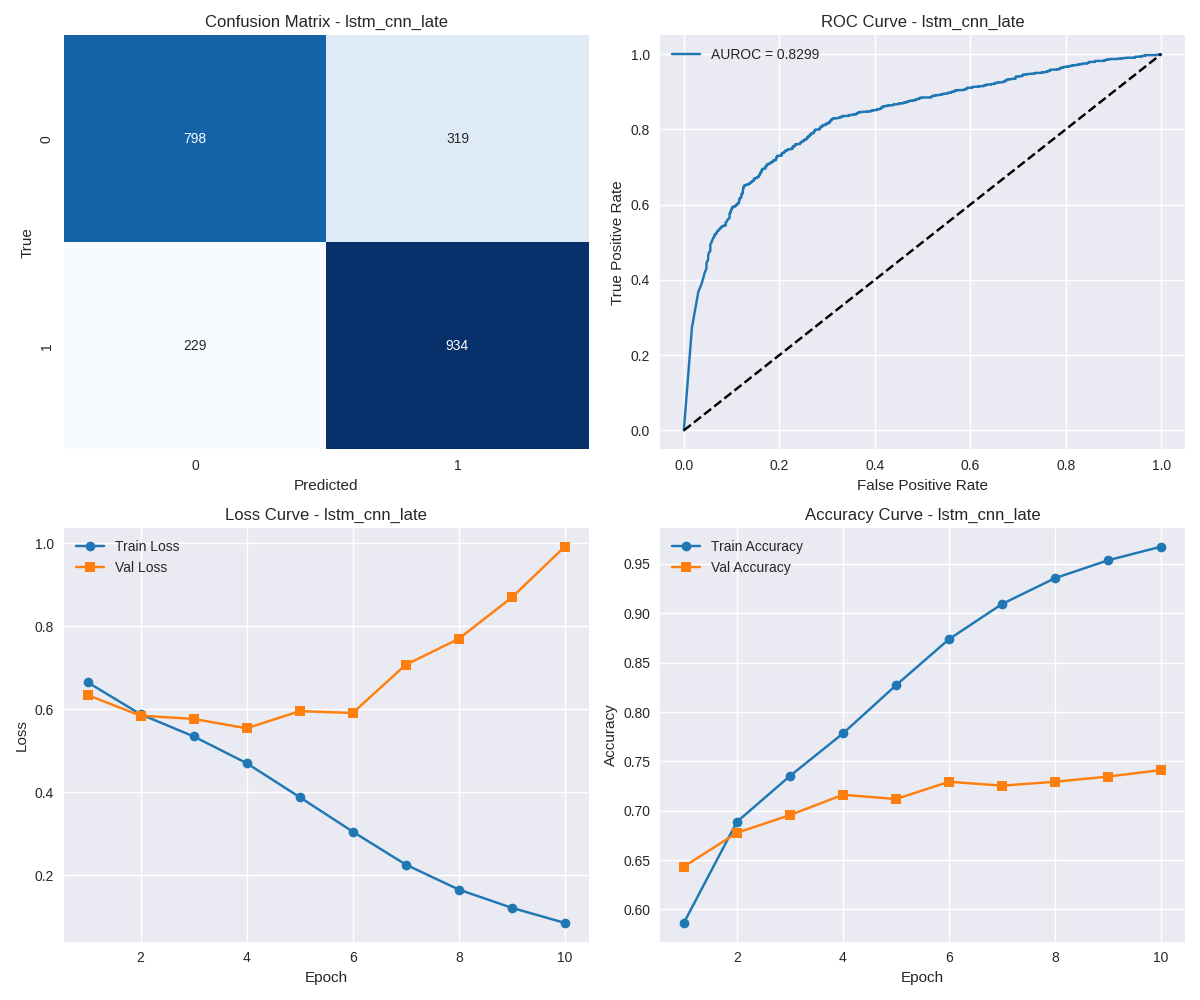


Training Metrics for lstm_cnn_late:



Prediction Analysis for lstm_cnn_late:


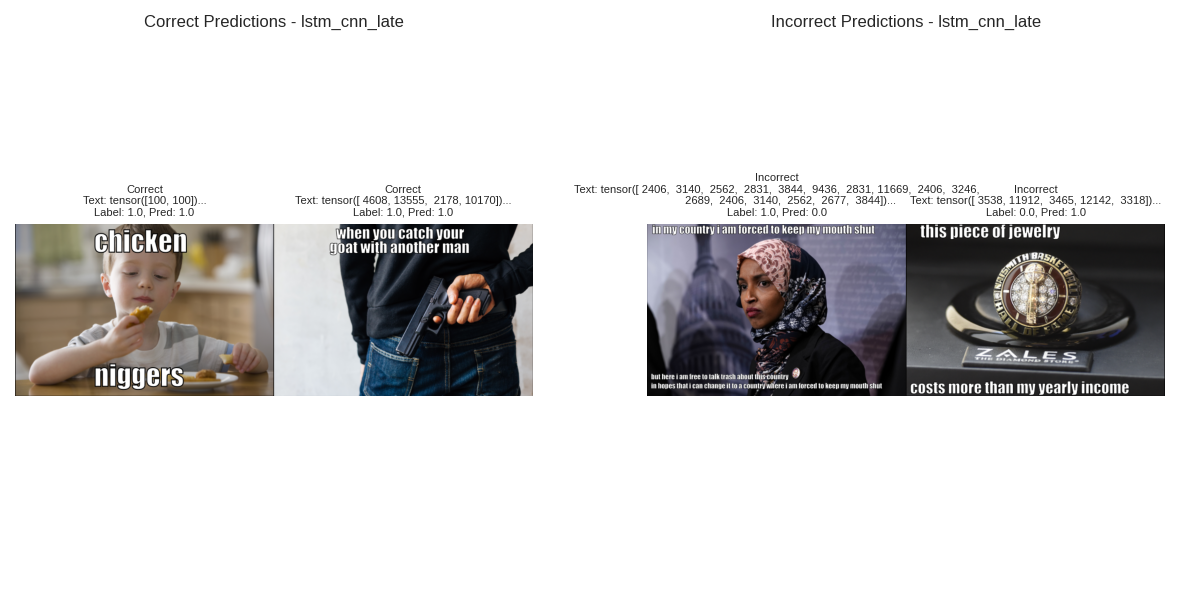


Results for lstm_resnet_late


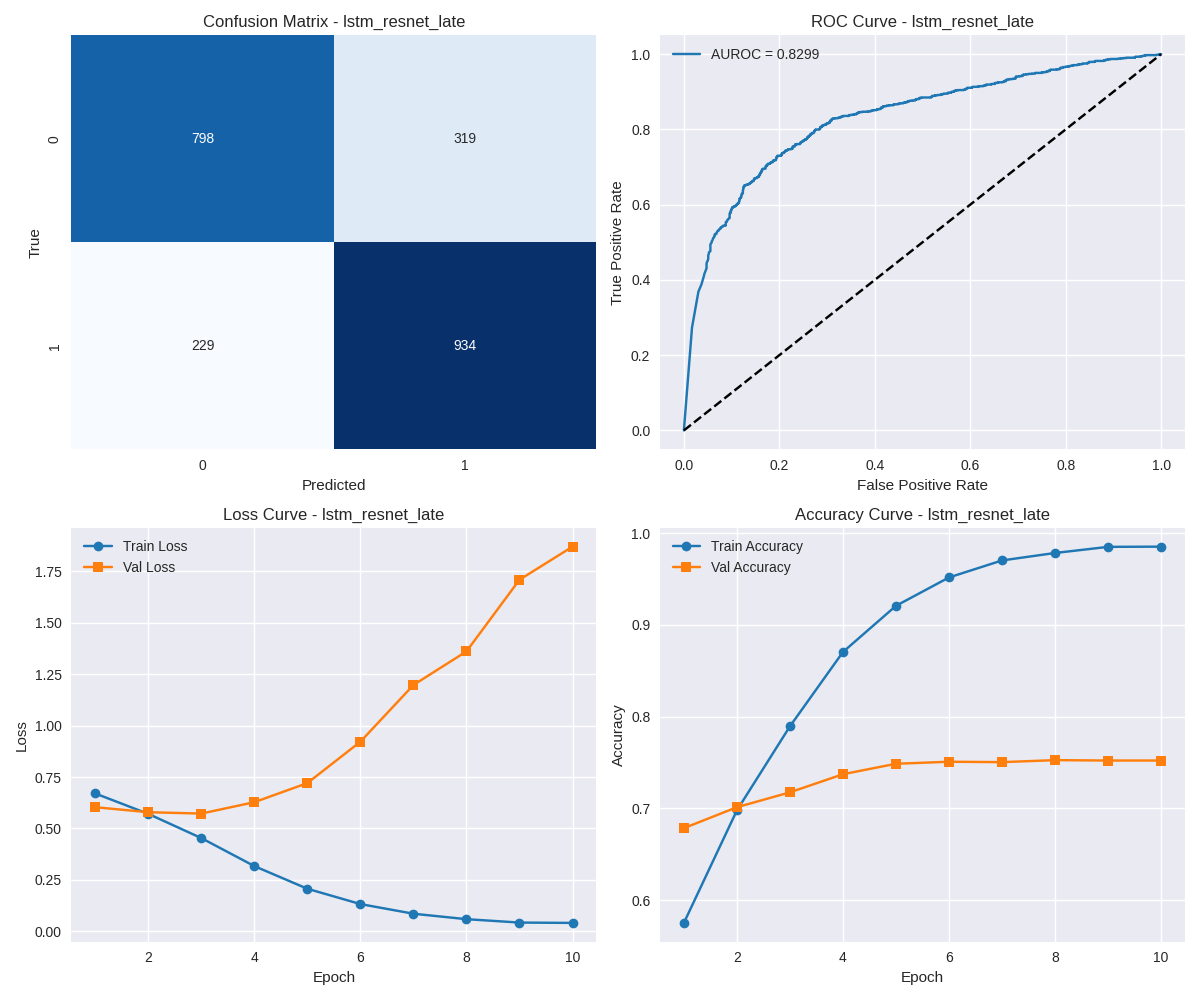


Training Metrics for lstm_resnet_late:



Results for bert_cnn_late


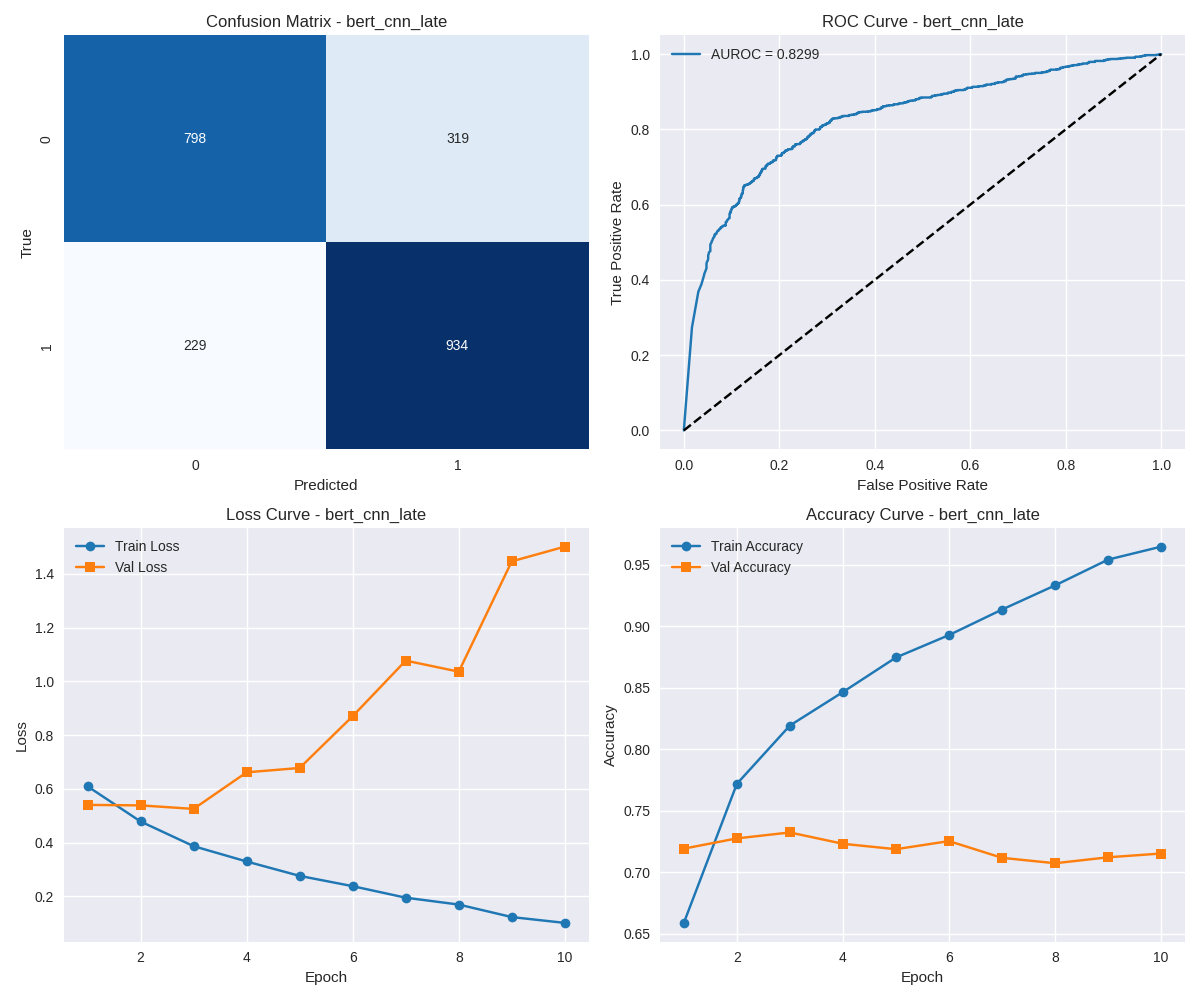


Training Metrics for bert_cnn_late:



Results for bert_resnet_late


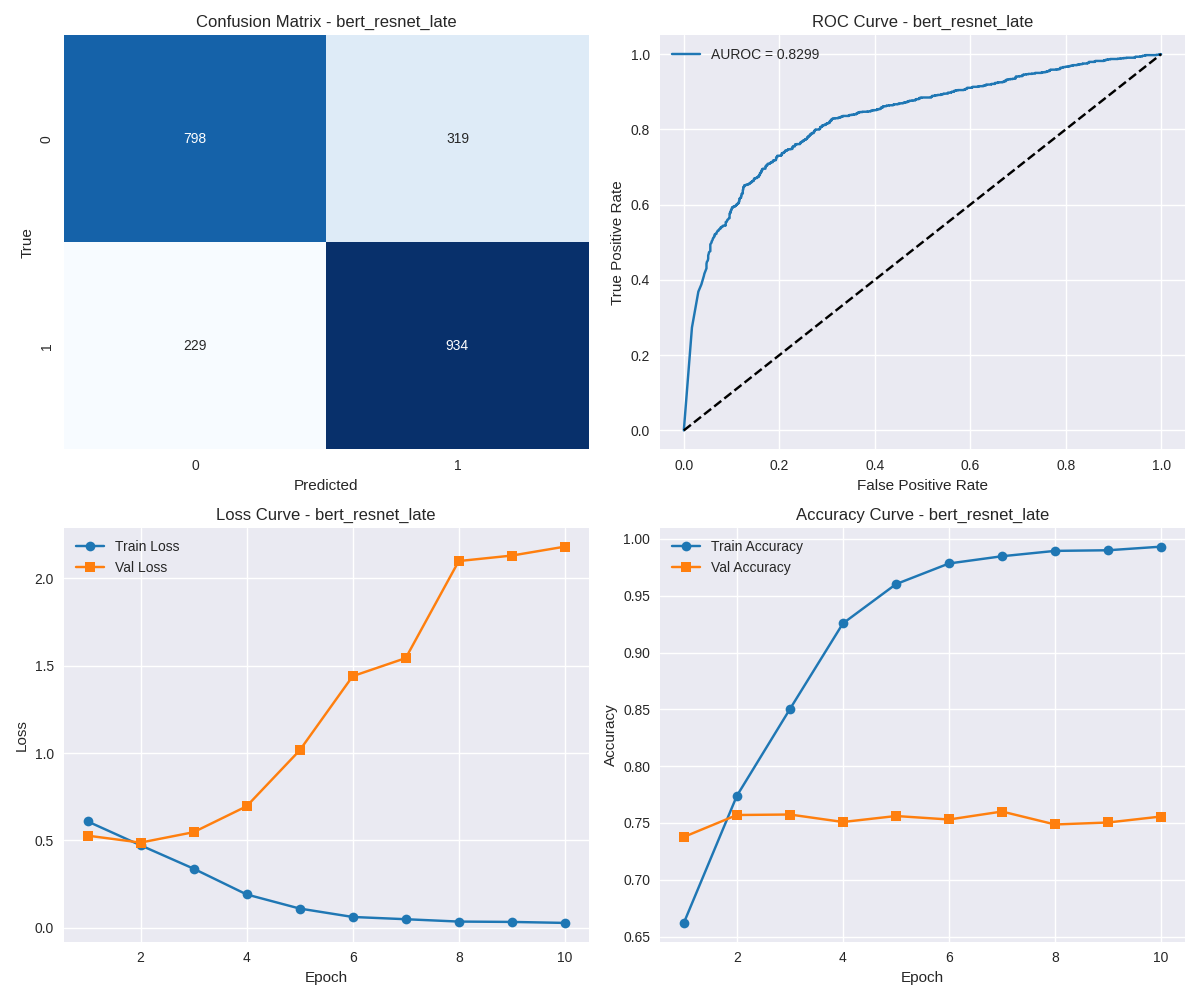


Training Metrics for bert_resnet_late:



Prediction Analysis for bert_resnet_late:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


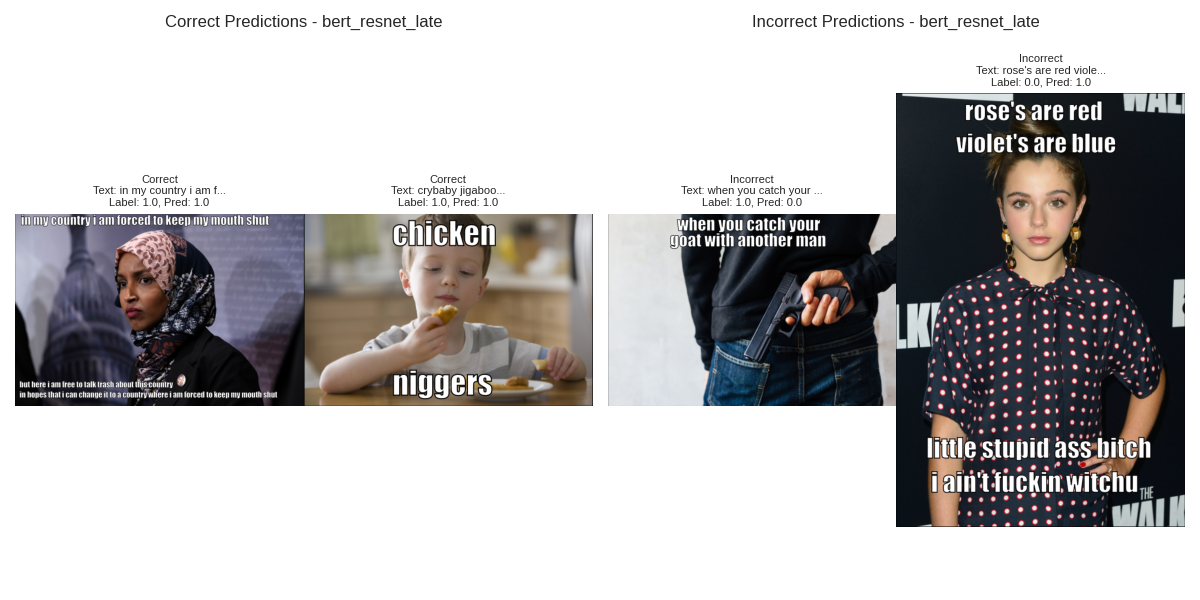


Results for lstm_cnn_early


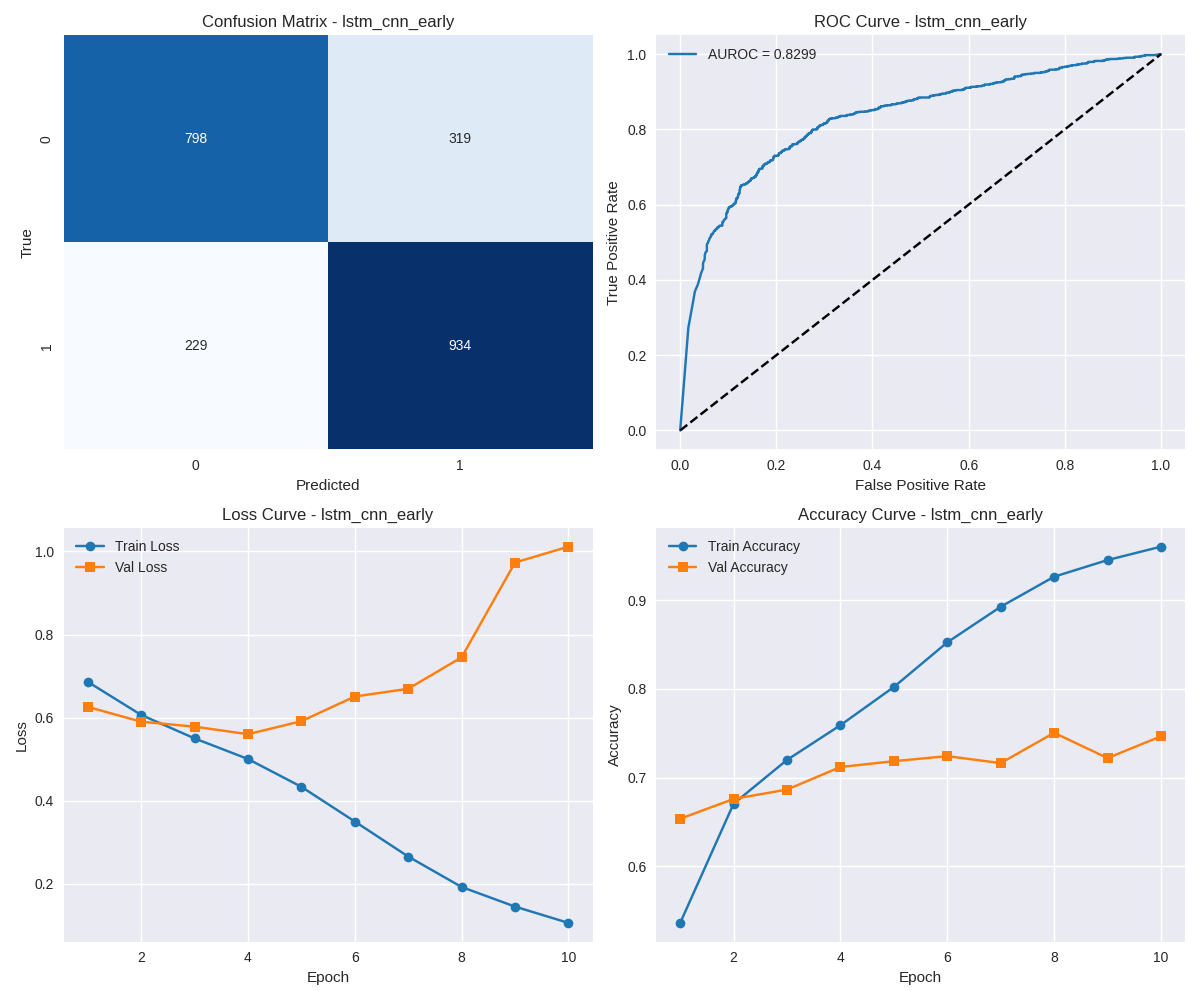


Training Metrics for lstm_cnn_early:



Results for lstm_resnet_early


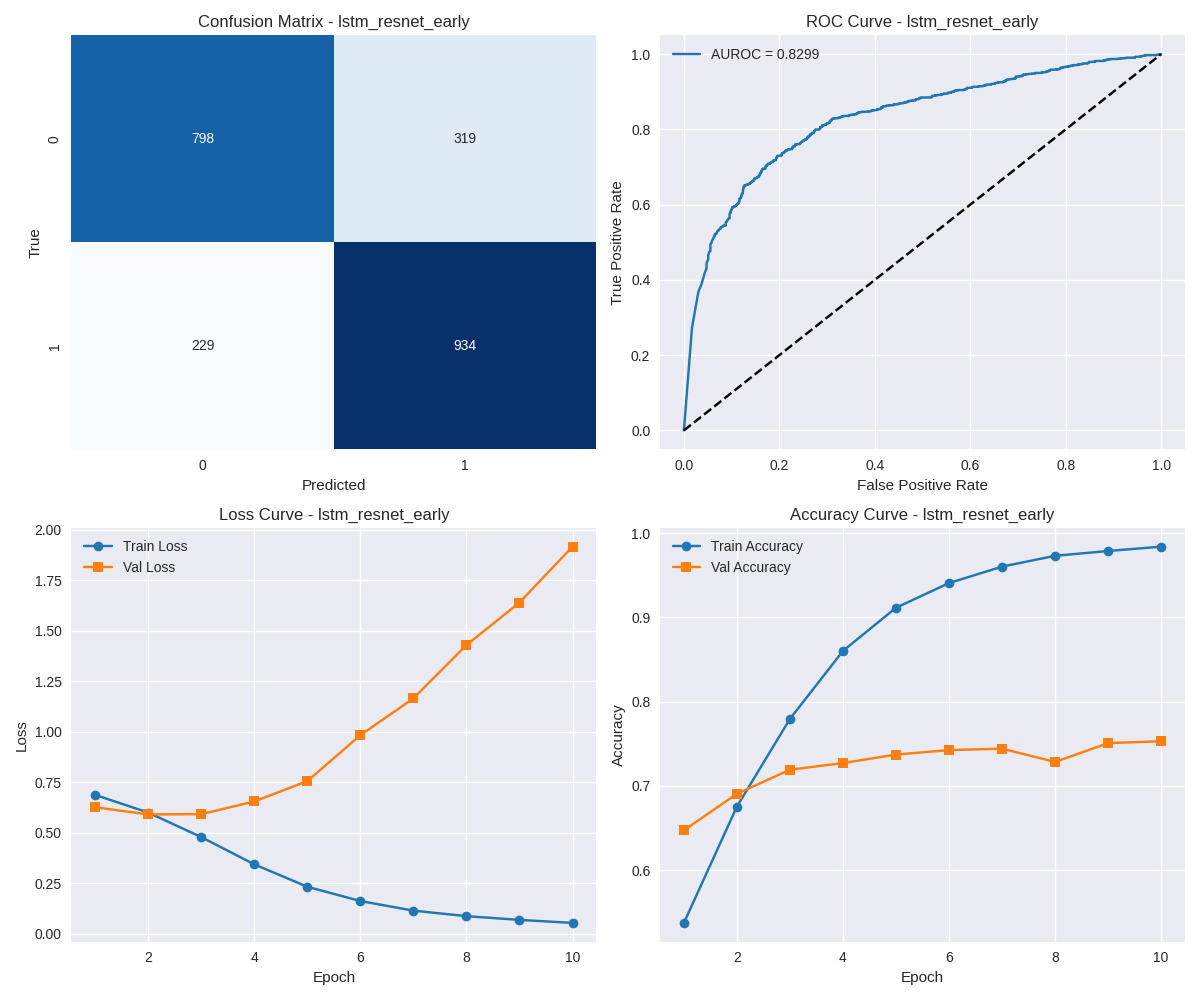


Training Metrics for lstm_resnet_early:



Results for bert_cnn_early


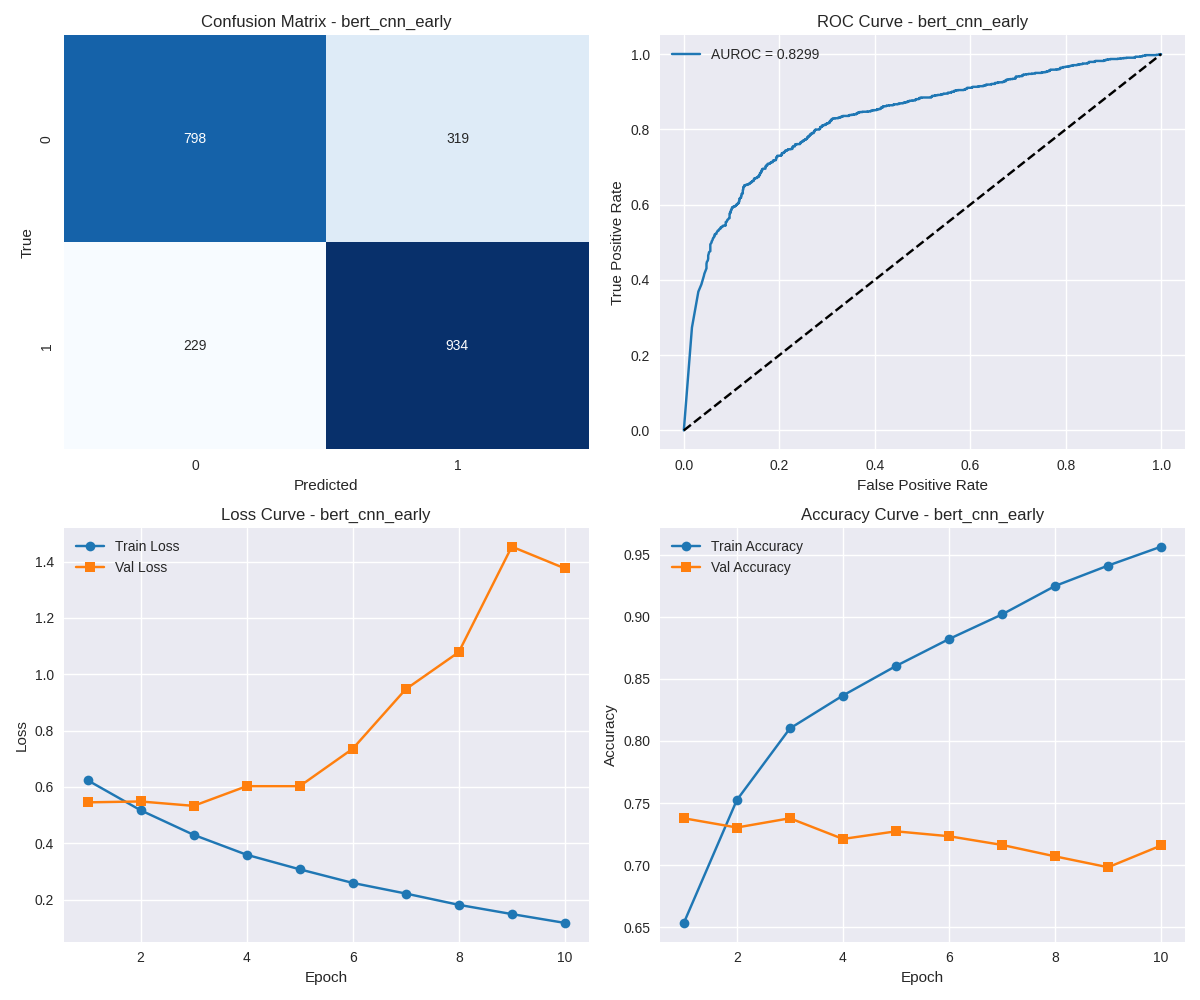


Training Metrics for bert_cnn_early:



Results for bert_resnet_early


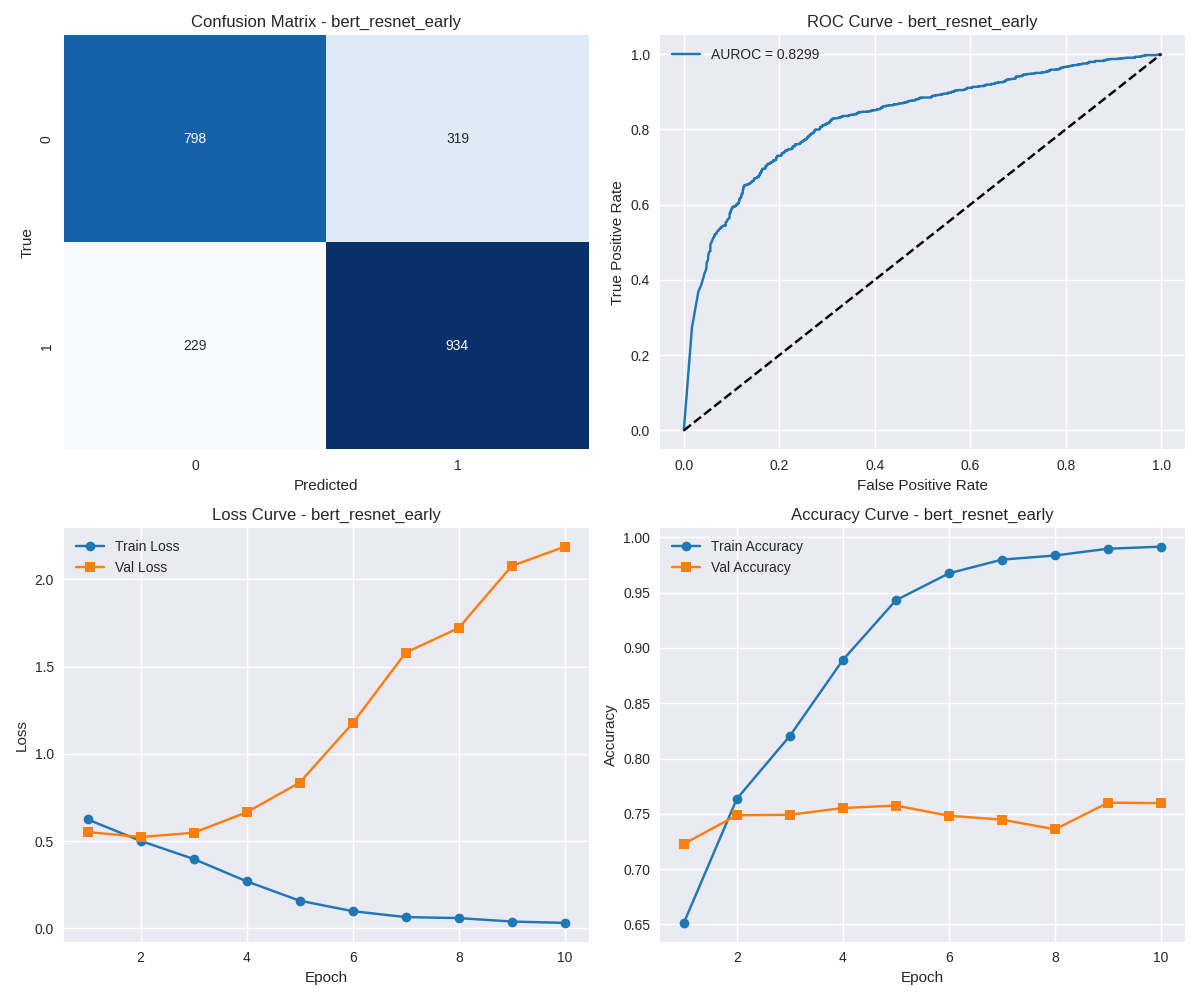


Training Metrics for bert_resnet_early:



Computational Efficiency Comparison

Computational Efficiency Table:



Computational Efficiency Plot:


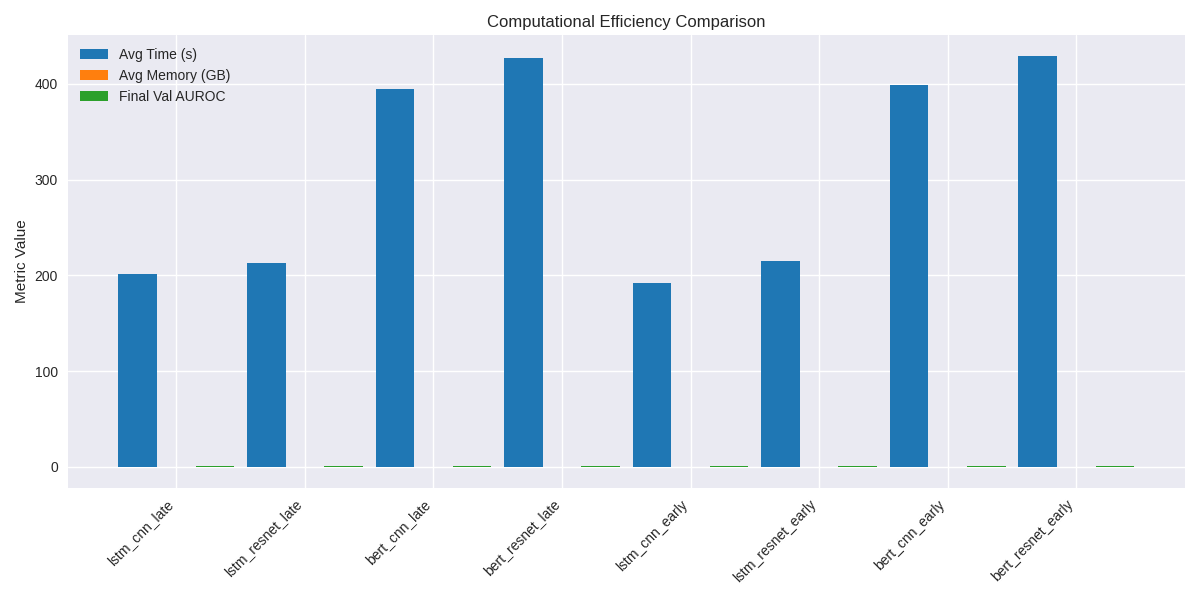

In [23]:
from IPython.display import display, Image as IPImage
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from PIL import Image
import torch
import numpy as np

# Define model names
model_names = [
    'lstm_cnn_late', 'lstm_resnet_late', 'bert_cnn_late', 'bert_resnet_late',
    'lstm_cnn_early', 'lstm_resnet_early', 'bert_cnn_early', 'bert_resnet_early'
]

# Confusion matrix
def plot_confusion_matrix(labels, preds, ax, model_name):
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix - {model_name}')

# ROC curve
def plot_roc_curve(labels, probs, ax, model_name):
    fpr, tpr, _ = roc_curve(labels, probs)
    ax.plot(fpr, tpr, label=f'AUROC = {roc_auc_score(labels, probs):.4f}')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}')
    ax.legend()

# Loss curve
def plot_loss_curve(log_df, ax, model_name):
    ax.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss', marker='o')
    ax.plot(log_df['epoch'], log_df['val_loss'], label='Val Loss', marker='s')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'Loss Curve - {model_name}')
    ax.legend()
    ax.grid(True)

# Accuracy curve
def plot_accuracy_curve(log_df, ax, model_name):
    ax.plot(log_df['epoch'], log_df['train_acc'], label='Train Accuracy', marker='o')
    ax.plot(log_df['epoch'], log_df['val_acc'], label='Val Accuracy', marker='s')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Accuracy Curve - {model_name}')
    ax.legend()
    ax.grid(True)

# Prediction analysis
def display_prediction_analysis(dataset, loader, model, model_name, num_samples=2, is_bert=False):
    model.eval()
    correct_samples = []
    incorrect_samples = []
    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device).float()
            texts = batch['text'] if 'input_ids' in batch else batch['text_raw']
            img_paths = batch['img_path']
            if 'input_ids' in batch:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids, attention_mask, images).squeeze()
            else:
                texts_tensor = batch['text'].to(device)
                lengths = batch['lengths'].to(device)
                valid_indices = lengths > 0
                if not valid_indices.any():
                    continue
                images = images[valid_indices]
                texts_tensor = texts_tensor[valid_indices]
                lengths = lengths[valid_indices]
                labels = labels[valid_indices]
                texts = [texts[i] for i in range(len(texts)) if valid_indices[i]]
                img_paths = [img_paths[i] for i in range(len(img_paths)) if valid_indices[i]]
                outputs = model(texts_tensor, lengths, images).squeeze()
            probs = torch.sigmoid(outputs).detach().cpu()
            preds = probs.round().numpy()
            labels = labels.cpu().numpy()
            for i in range(len(labels)):
                sample = {
                    'image': Image.open(img_paths[i]).convert('RGB'),
                    'text': texts[i],
                    'label': labels[i],
                    'pred': preds[i],
                    'prob': probs[i]
                }
                if preds[i] == labels[i]:
                    correct_samples.append(sample)
                else:
                    incorrect_samples.append(sample)
    # Create a 1x2 figure for correct and incorrect samples
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # Correct samples
    for i, sample in enumerate(correct_samples[:num_samples]):
        sub_ax = axes[0].inset_axes([i * 0.5, 0, 0.5, 1])
        sub_ax.imshow(sample['image'])
        sub_ax.set_title(f"Correct\nText: {sample['text'][:20]}...\nLabel: {sample['label']}, Pred: {sample['pred']}", fontsize=8)
        sub_ax.axis('off')
    axes[0].set_title(f'Correct Predictions - {model_name}')
    axes[0].axis('off')
    # Incorrect samples
    for i, sample in enumerate(incorrect_samples[:num_samples]):
        sub_ax = axes[1].inset_axes([i * 0.5, 0, 0.5, 1])
        sub_ax.imshow(sample['image'])
        sub_ax.set_title(f"Incorrect\nText: {sample['text'][:20]}...\nLabel: {sample['label']}, Pred: {sample['pred']}", fontsize=8)
        sub_ax.axis('off')
    axes[1].set_title(f'Incorrect Predictions - {model_name}')
    axes[1].axis('off')
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/pred_{model_name}.png')
    plt.close()
    return IPImage(f'/kaggle/working/pred_{model_name}.png')

# Consolidated display for each model
for model_name in model_names:
    print(f"\n{'='*50}\nResults for {model_name}\n{'='*50}")
    
    # Create a 2x2 subplot figure for confusion matrix, ROC curve, loss, and accuracy
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    # Plot visualizations
    log_df = pd.read_csv(f'logs_{model_name}.csv')
    plot_confusion_matrix(val_labels, val_preds, axes[0], model_name)
    plot_roc_curve(val_labels, val_probs, axes[1], model_name)
    plot_loss_curve(log_df, axes[2], model_name)
    plot_accuracy_curve(log_df, axes[3], model_name)
    
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/results_{model_name}.png')
    plt.close()
    
    # Display the figure
    display(IPImage(f'/kaggle/working/results_{model_name}.png'))
    
    # Display training metrics
    print(f"\nTraining Metrics for {model_name}:")
    display(log_df[['epoch', 'train_loss', 'val_loss', 'train_acc', 'val_acc', 
                    'train_f1', 'val_f1', 'train_auroc', 'val_auroc']].style.set_caption(f'Metrics for {model_name}').format('{:.4f}'))
    
    # Prediction analysis for lstm_cnn_late and bert_resnet_late
    if model_name in ['lstm_cnn_late', 'bert_resnet_late']:
        print(f"\nPrediction Analysis for {model_name}:")
        is_bert = model_name == 'bert_resnet_late'
        if is_bert:
            model = LateFusionModelBERT().to(device)
        else:
            model = LateFusionModelLSTM(vocab_size=len(bert_tokenizer.vocab)).to(device)
        model.load_state_dict(torch.load(f'best_{model_name}.pth'))
        pred_image = display_prediction_analysis(
            bert_val_dataset if is_bert else lstm_val_dataset,
            bert_val_loader if is_bert else lstm_val_loader,
            model, model_name, is_bert=is_bert
        )
        display(pred_image)

# Computational efficiency comparison
print(f"\n{'='*50}\nComputational Efficiency Comparison\n{'='*50}")
final_metrics = []
for model_name in model_names:
    log_df = pd.read_csv(f'logs_{model_name}.csv')
    final_metrics.append({
        'Model': model_name,
        'Avg Time (s)': log_df['elapsed_time'].mean(),
        'Avg Memory (GB)': log_df['memory_usage'].mean(),
        'Final Val AUROC': log_df['val_auroc'].iloc[-1]
    })
efficiency_df = pd.DataFrame(final_metrics)
print("\nComputational Efficiency Table:")
display(efficiency_df.style.set_caption('Computational Efficiency').format({
    'Avg Time (s)': '{:.2f}',
    'Avg Memory (GB)': '{:.2f}',
    'Final Val AUROC': '{:.4f}'
}))

plt.figure(figsize=(12, 6))
x = range(len(efficiency_df))
width = 0.3
plt.bar([i - width for i in x], efficiency_df['Avg Time (s)'], width, label='Avg Time (s)')
plt.bar(x, efficiency_df['Avg Memory (GB)'], width, label='Avg Memory (GB)')
plt.bar([i + width for i in x], efficiency_df['Final Val AUROC'], width, label='Final Val AUROC')
plt.xticks(x, efficiency_df['Model'], rotation=45, ha='right')
plt.title('Computational Efficiency Comparison')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('/kaggle/working/efficiency_comparison.png')
plt.close()
print("\nComputational Efficiency Plot:")
display(IPImage('/kaggle/working/efficiency_comparison.png'))

/tmp/ipykernel_35/1060109420.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


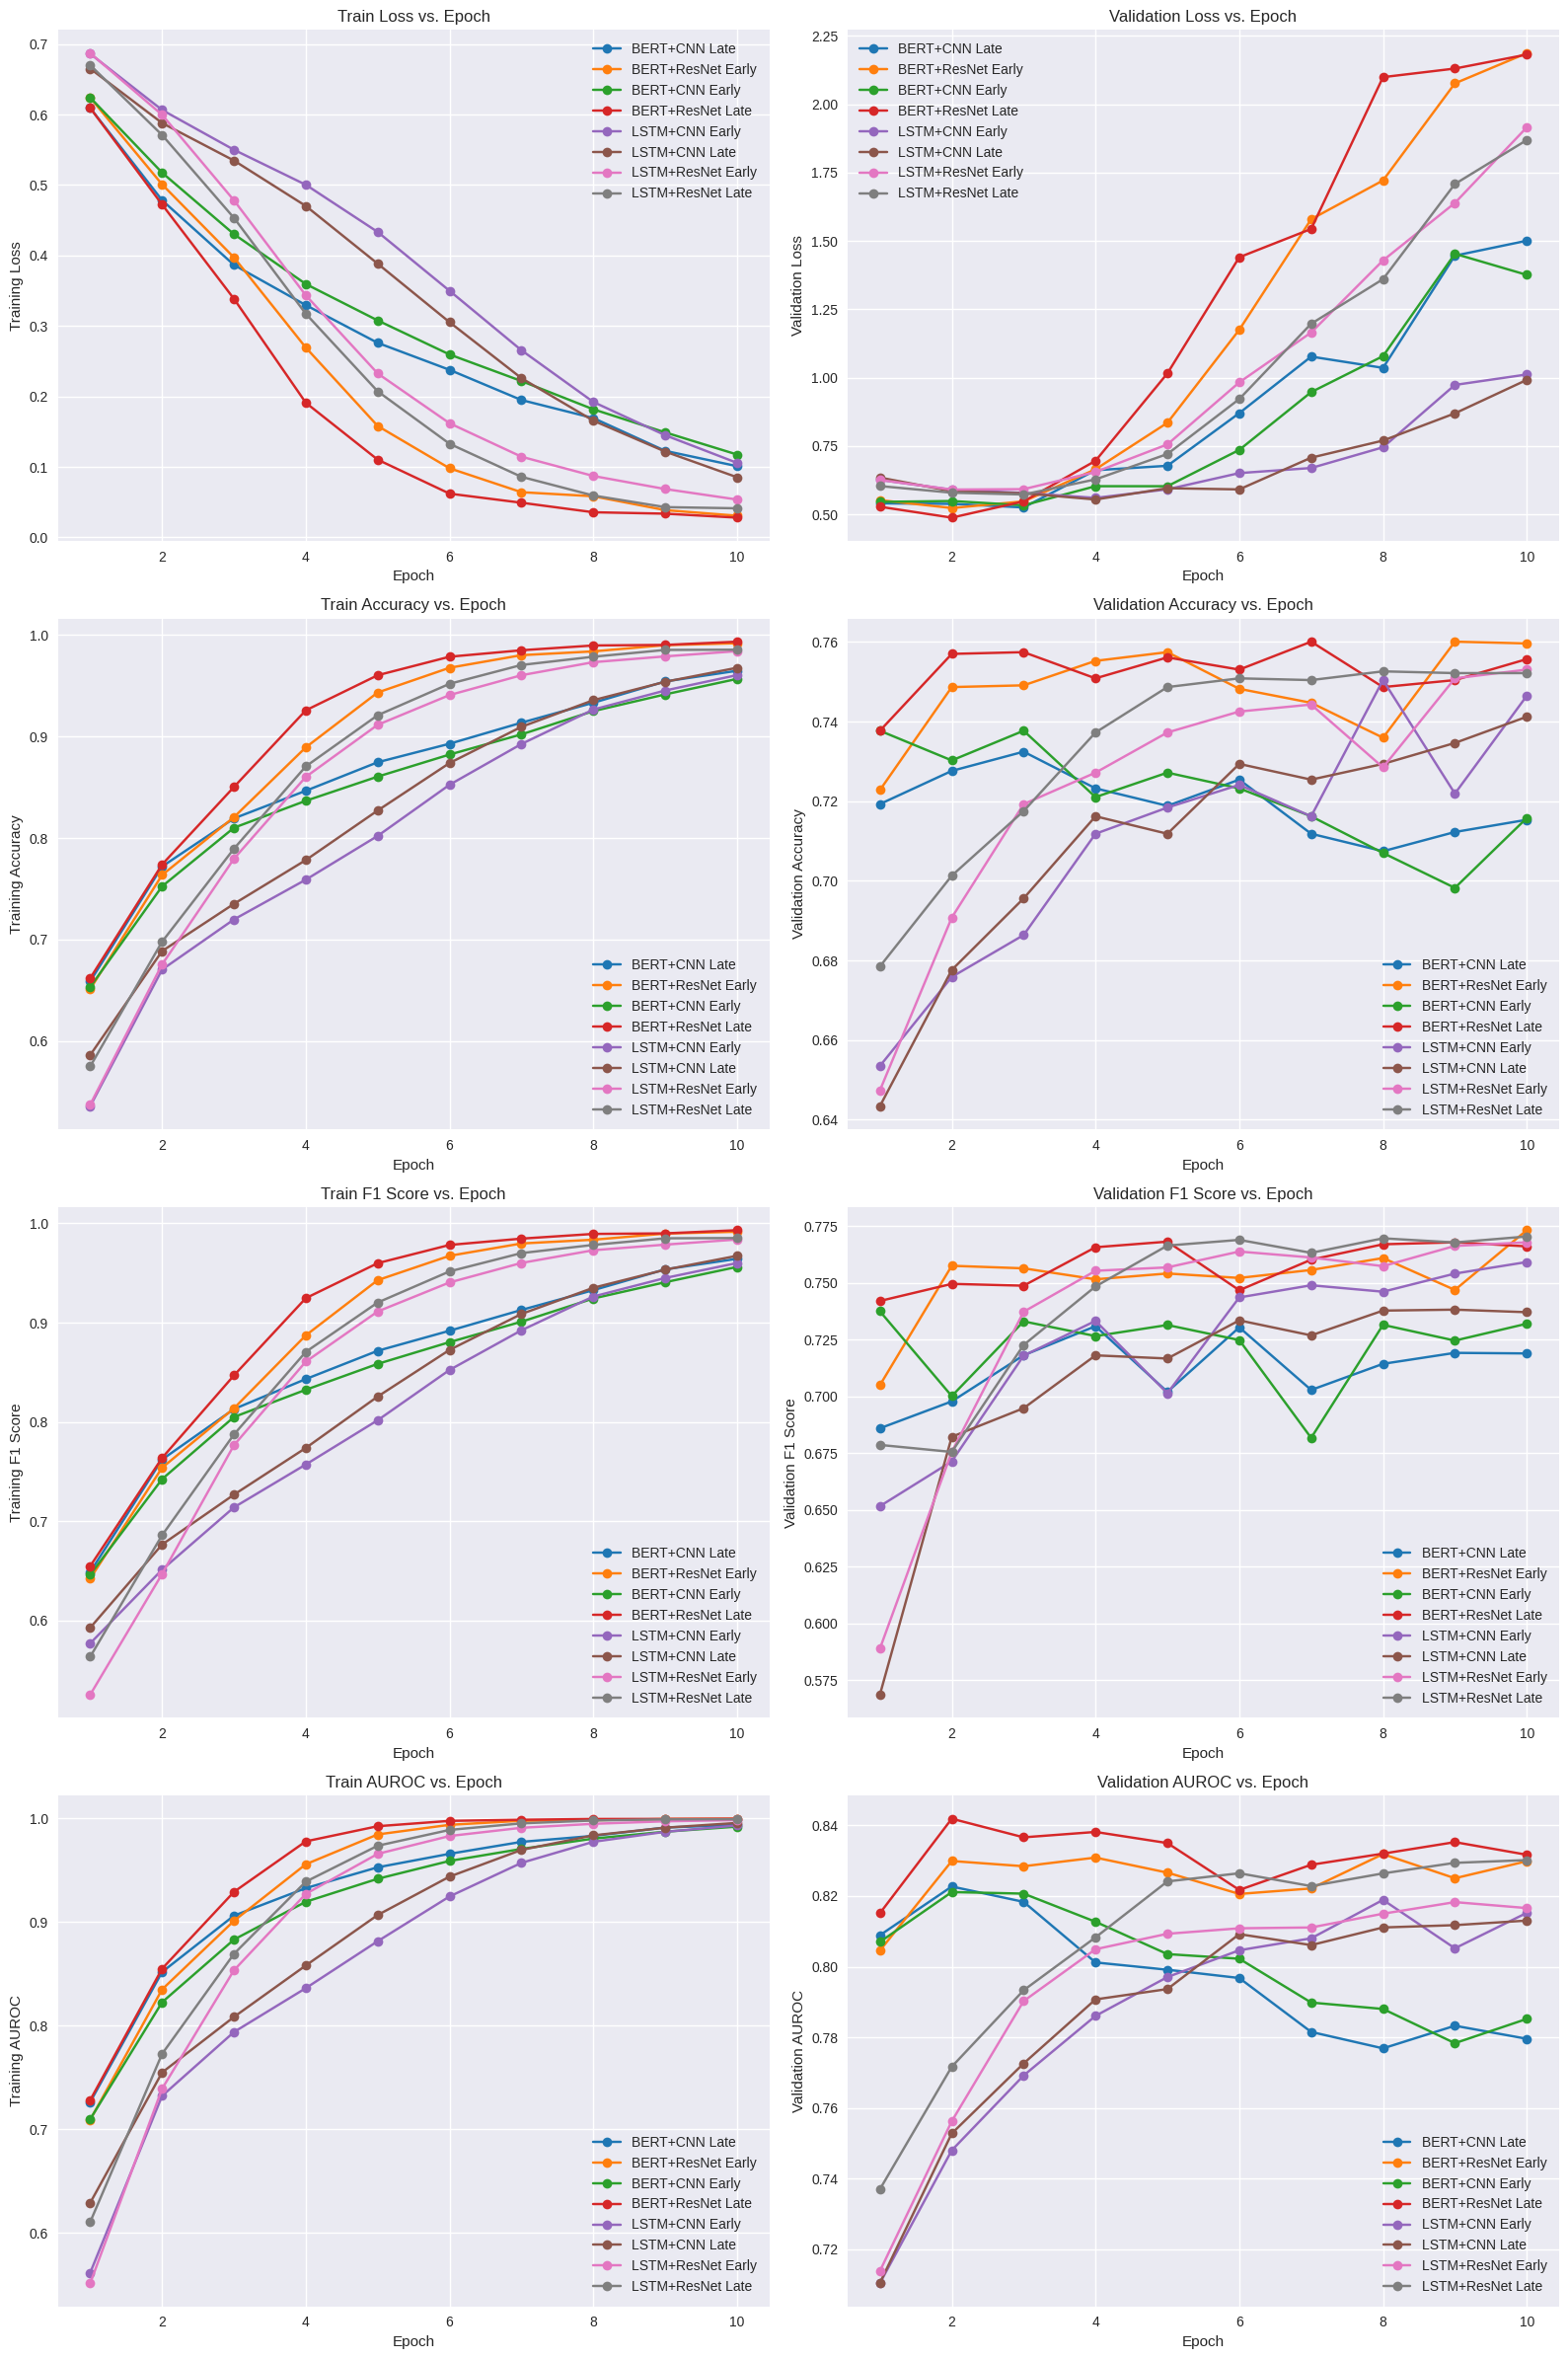

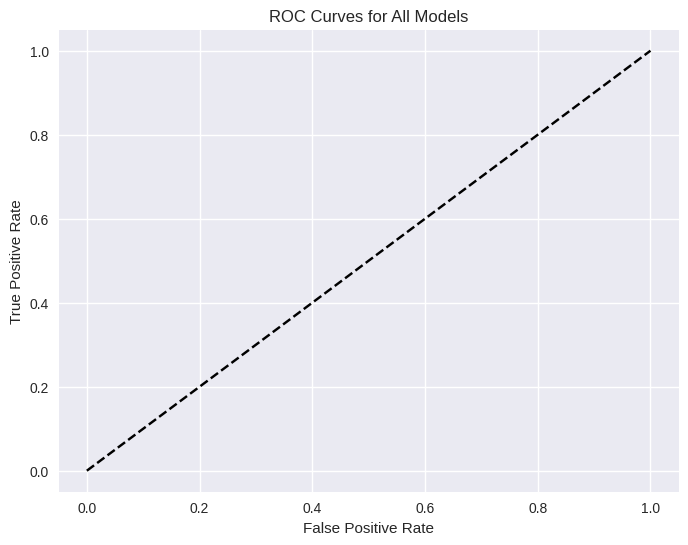

Note: ROC curves require val_labels and val_probs. Please save these during training (e.g., as .npy files) and update the code to load them.


In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# Set plot style
plt.style.use('seaborn')
sns.set_palette("tab10")

# Define model names and corresponding CSV files
log_dir = '/kaggle/working/'
csv_files = glob.glob(os.path.join(log_dir, 'logs_*.csv'))

if not csv_files:
    raise FileNotFoundError("No log CSV files found in /kaggle/working/")

# Map filenames to readable model names
model_name_map = {
    'logs_lstm_cnn_late.csv': 'LSTM+CNN Late',
    'logs_lstm_resnet_late.csv': 'LSTM+ResNet Late',
    'logs_bert_cnn_late.csv': 'BERT+CNN Late',
    'logs_bert_resnet_late.csv': 'BERT+ResNet Late',
    'logs_lstm_cnn_early.csv': 'LSTM+CNN Early',
    'logs_lstm_resnet_early.csv': 'LSTM+ResNet Early',
    'logs_bert_cnn_early.csv': 'BERT+CNN Early',
    'logs_bert_resnet_early.csv': 'BERT+ResNet Early'
}

# Read CSVs into a dictionary of DataFrames
logs = {}
for csv_file in csv_files:
    filename = os.path.basename(csv_file)
    if filename in model_name_map:
        df = pd.read_csv(csv_file)
        required_columns = {'epoch', 'train_loss', 'val_loss', 'train_acc', 'val_acc',
                           'train_f1', 'val_f1', 'train_auroc', 'val_auroc'}
        if required_columns.issubset(df.columns):
            logs[model_name_map[filename]] = df
        else:
            print(f"Warning: {filename} missing required columns, skipping.")

if not logs:
    raise ValueError("No valid log CSVs with required columns found.")

# Create a figure with 8 subplots (2 rows, 4 columns)
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
axes = axes.flatten()

# Metrics to plot
metrics = [
    ('train_loss', 'Training Loss', 'Train Loss vs. Epoch'),
    ('val_loss', 'Validation Loss', 'Validation Loss vs. Epoch'),
    ('train_acc', 'Training Accuracy', 'Train Accuracy vs. Epoch'),
    ('val_acc', 'Validation Accuracy', 'Validation Accuracy vs. Epoch'),
    ('train_f1', 'Training F1 Score', 'Train F1 Score vs. Epoch'),
    ('val_f1', 'Validation F1 Score', 'Validation F1 Score vs. Epoch'),
    ('train_auroc', 'Training AUROC', 'Train AUROC vs. Epoch'),
    ('val_auroc', 'Validation AUROC', 'Validation AUROC vs. Epoch')
]

# Plot each metric
for idx, (metric, ylabel, title) in enumerate(metrics):
    ax = axes[idx]
    for model_name, df in logs.items():
        ax.plot(df['epoch'], df[metric], label=model_name, marker='o')
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.savefig('/kaggle/working/all_metrics_comparison.png')
plt.show()

# ROC Curves (Placeholder - requires val_labels and val_probs)
# Note: val_labels and val_probs are not saved in CSVs. You need to provide them.
# Example: Save val_probs and val_labels during training as .npy files and load here.
fig, ax = plt.subplots(figsize=(8, 6))
# Example placeholder code (uncomment and modify if you have saved val_probs and val_labels)
"""
for model_name in logs.keys():
    # Load val_probs and val_labels (modify paths as needed)
    val_probs = np.load(f'/kaggle/working/val_probs_{model_name.replace(" ", "_").lower()}.npy')
    val_labels = np.load('/kaggle/working/val_labels.npy')  # Assuming shared labels
    fpr, tpr, _ = roc_curve(val_labels, val_probs)
    auc_score = roc_auc_score(val_labels, val_probs)
    ax.plot(fpr, tpr, label=f'{model_name} (AUROC = {auc_score:.4f})')
"""
ax.plot([0, 1], [0, 1], 'k--')
ax.set_title('ROC Curves for All Models')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
ax.grid(True)
plt.savefig('/kaggle/working/roc_curves_all_models.png')
plt.show()
print("Note: ROC curves require val_labels and val_probs. Please save these during training (e.g., as .npy files) and update the code to load them.")